In [26]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# root_path = '/content/drive/Othercomputers/My Laptop/2nd_FlyDrive/myProjects/AI/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
root_path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# !pip install wfdb

In the WFDB-format every ECG is represented by a tuple of two files, a mat-file containing the binary raw data and a corresponding header file with the same name and hea-extension. The head file contained annotation information including lead configuration, age, gender, and SNOMED CT code.

In [5]:
#imports 

import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import wfdb # WaveForm DataBase software package, provides tools for working with biomedical time-series data.
import os
import ast
from ecgdetectors import Detectors
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Import the PyWavelets library
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import StandardScaler
import joblib

# provides facilities for working with the abstract syntax trees of Python code.
# An Abstract Syntax Tree (AST) is a hierarchical tree-like structure that represents the syntactic structure of a program.

# Reading Datas

In [9]:
root_path = './ptb-xl-dataset-1.0.3/'
ecg_data = pd.read_csv('./ptb-xl-dataset-1.0.3/ptbxl_database.csv' , usecols= ['sex', 'height', 'weight', 'strat_fold','scp_codes', 'infarction_stadium1' , 'infarction_stadium2', 'heart_axis' , 'pacemaker' ,'filename_lr', 'filename_hr'])
print( len(ecg_data) )
# ecg_data = ecg_data.sort_values(by='strat_fold')
ecg_data = ecg_data[:5000]

scp_data = pd.read_csv(root_path + 'scp_statements.csv' , index_col= 0)#, usecols= ['diagnostic','diagnostic_class']  )

# read a WFDB record (physiological signal record) from a specified file:

# data = [wfdb.rdsamp(os.path.join(root_path, file)) for file in ecg_data.filename_lr]
# ecg_signal = np.array( [signal for signal, meta in data])
ecg_signal = np.array([wfdb.rdsamp(os.path.join(root_path, file))[0] for file in ecg_data.filename_lr])

print( len(ecg_data) )
ecg_data
# scp_data
# ecg_data.filename_lr[0]
# ecg_data.filename_lr
# # ecg_signal

21799
5000


sex  height  weight                                          scp_codes  \
0       1     NaN    63.0           {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}   
1       0     NaN    70.0                       {'NORM': 80.0, 'SBRAD': 0.0}   
2       1     NaN    69.0                         {'NORM': 100.0, 'SR': 0.0}   
3       0     NaN    82.0                         {'NORM': 100.0, 'SR': 0.0}   
4       1     NaN    70.0                         {'NORM': 100.0, 'SR': 0.0}   
...   ...     ...     ...                                                ...   
4995    0   178.0    80.0             {'NORM': 100.0, 'LPR': 0.0, 'SR': 0.0}   
4996    0     NaN     NaN                      {'IRBBB': 100.0, 'AFIB': 0.0}   
4997    0     NaN     NaN  {'IMI': 15.0, 'ISCAL': 100.0, 'ABQRS': 0.0, 'S...   
4998    0     NaN     NaN                      {'LVH': 100.0, 'ISC_': 100.0}   
4999    0     NaN     NaN                          {'NORM': 50.0, 'SR': 0.0}   

     heart_axis infarction_stadium1 infarction_stadium2 pacemaker  strat_fold  \
0           NaN                 NaN                 NaN       NaN           3   
1           NaN                 NaN                 NaN       NaN           2   
2           NaN                 NaN                 NaN       NaN           5   
3           NaN                 NaN                 NaN       NaN           3   
4           NaN                 NaN                 NaN       NaN           4   
...         ...                 ...                 ...       ...         ...   
4995        NaN                 NaN                 NaN       NaN           2   
4996        MID                 NaN                 NaN       NaN           5   
4997        MID             unknown                 NaN       NaN           3   
4998        NaN                 NaN                 NaN       NaN           1   
4999        LAD                 NaN                 NaN       NaN           8   

                    filename_lr                filename_hr  
0     records100/00000/00001_lr  records500/00000/00001_hr  
1     records100/00000/00002_lr  records500/00000/00002_hr  
2     records100/00000/00003_lr  records500/00000/00003_hr  
3     records100/00000/00004_lr  records500/00000/00004_hr  
4     records100/00000/00005_lr  records500/00000/00005_hr  
...                         ...                        ...  
4995  records100/05000/05015_lr  records500/05000/05015_hr  
4996  records100/05000/05016_lr  records500/05000/05016_hr  
4997  records100/05000/05017_lr  records500/05000/05017_hr  
4998  records100/05000/05018_lr  records500/05000/05018_hr  
4999  records100/05000/05019_lr  records500/05000/05019_hr  

[5000 rows x 11 columns]

In [10]:
# safely evaluate a string containing a Python literal or container display
ecg_data['scp_codes'] = ecg_data['scp_codes'].apply(lambda x: ast.literal_eval(x))
ecg_data['scp_codes']

0                {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
1                            {'NORM': 80.0, 'SBRAD': 0.0}
2                              {'NORM': 100.0, 'SR': 0.0}
3                              {'NORM': 100.0, 'SR': 0.0}
4                              {'NORM': 100.0, 'SR': 0.0}
                              ...                        
4995               {'NORM': 100.0, 'LPR': 0.0, 'SR': 0.0}
4996                        {'IRBBB': 100.0, 'AFIB': 0.0}
4997    {'IMI': 15.0, 'ISCAL': 100.0, 'ABQRS': 0.0, 'S...
4998                        {'LVH': 100.0, 'ISC_': 100.0}
4999                            {'NORM': 50.0, 'SR': 0.0}
Name: scp_codes, Length: 5000, dtype: object

In [11]:
scp_data['diagnostic_class'].value_counts()

MI      14
STTC    13
CD      11
HYP      5
NORM     1
Name: diagnostic_class, dtype: int64

In [12]:
def superclasses(scp): # find diagnostic_class for every key in ecg_data['scp_codes']
    res = set()
    for k in scp.keys():
        if k in scp_data.index:
            res.add( scp_data.loc[k].diagnostic_class)
    
    return list(res)

sample = ecg_signal[1]

scp_data = scp_data.dropna(subset=['diagnostic_class'])

ecg_data['scp_classes'] = ecg_data['scp_codes'].apply(superclasses)
ecg_data['scp_classes']

0            [NORM]
1            [NORM]
2            [NORM]
3            [NORM]
4            [NORM]
           ...     
4995         [NORM]
4996           [CD]
4997     [STTC, MI]
4998    [STTC, HYP]
4999         [NORM]
Name: scp_classes, Length: 5000, dtype: object

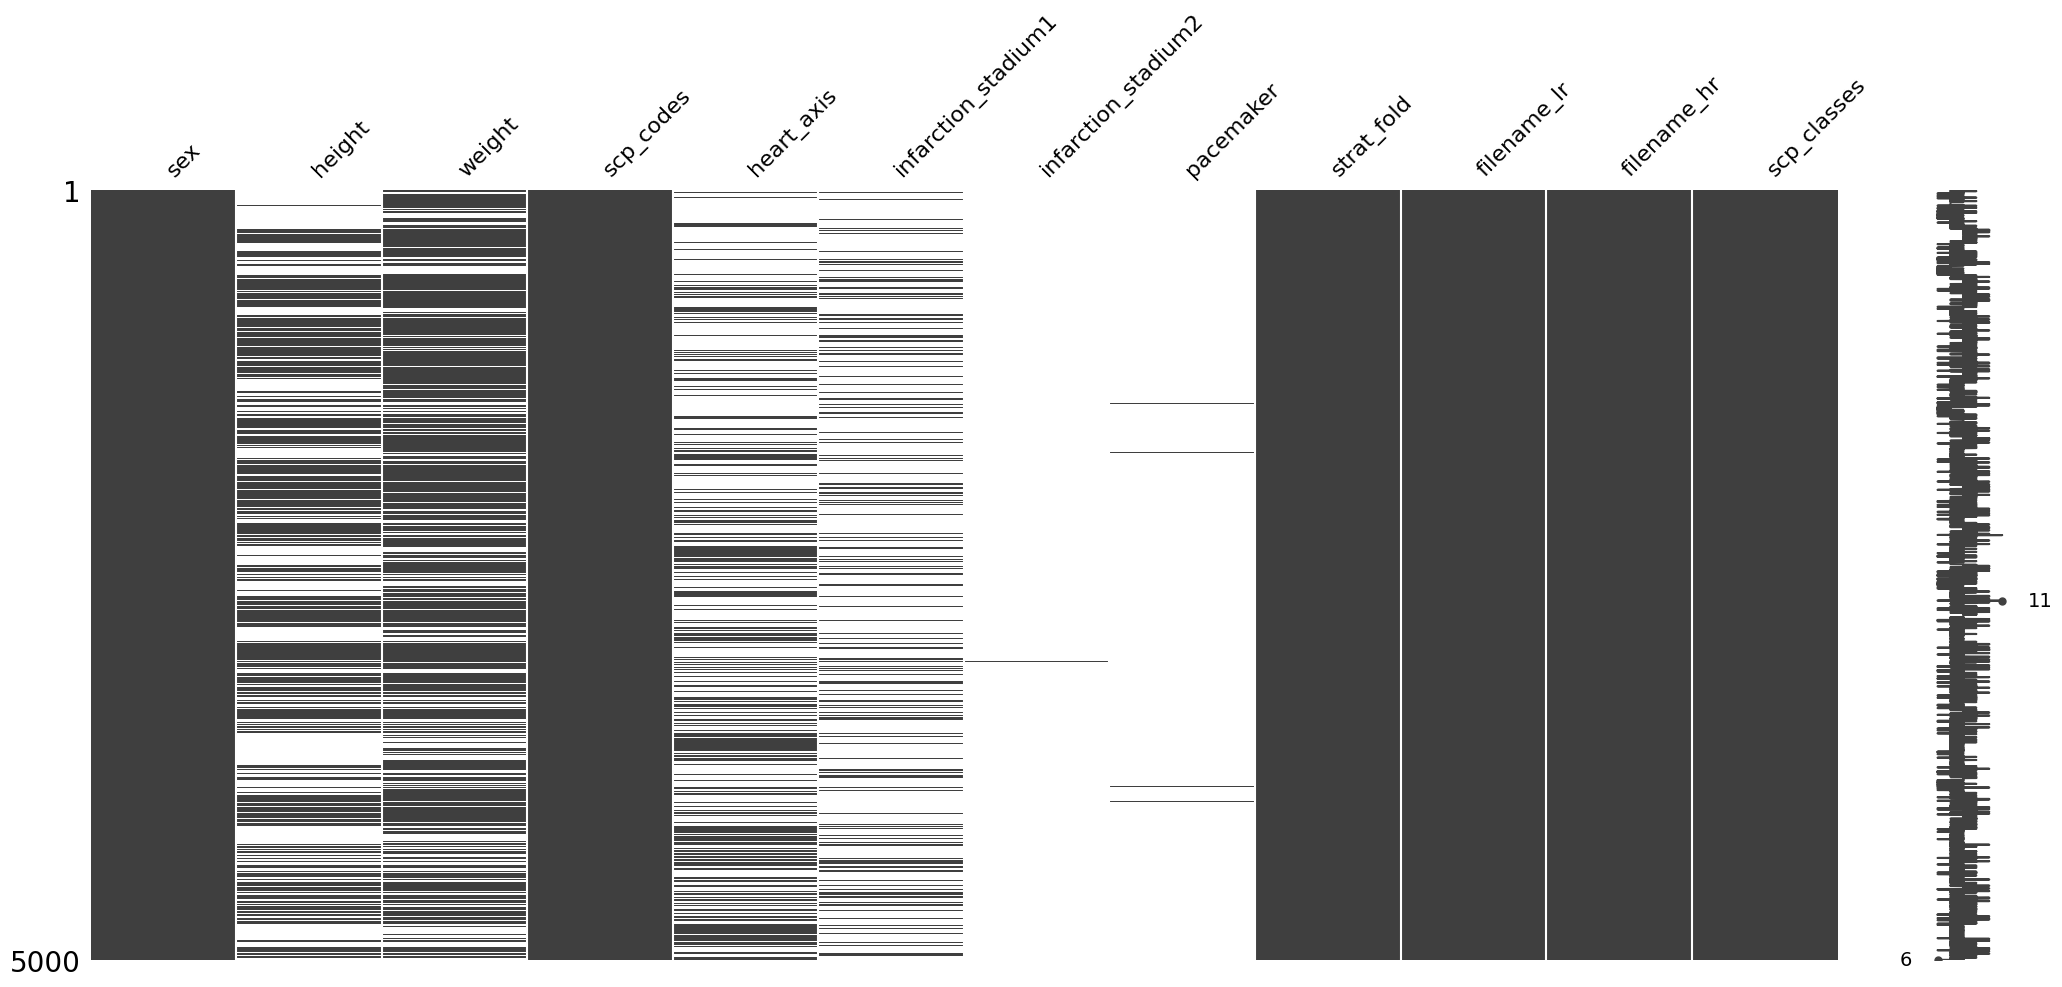

In [13]:
import missingno as msno
msno.matrix(ecg_data)
plt.show()

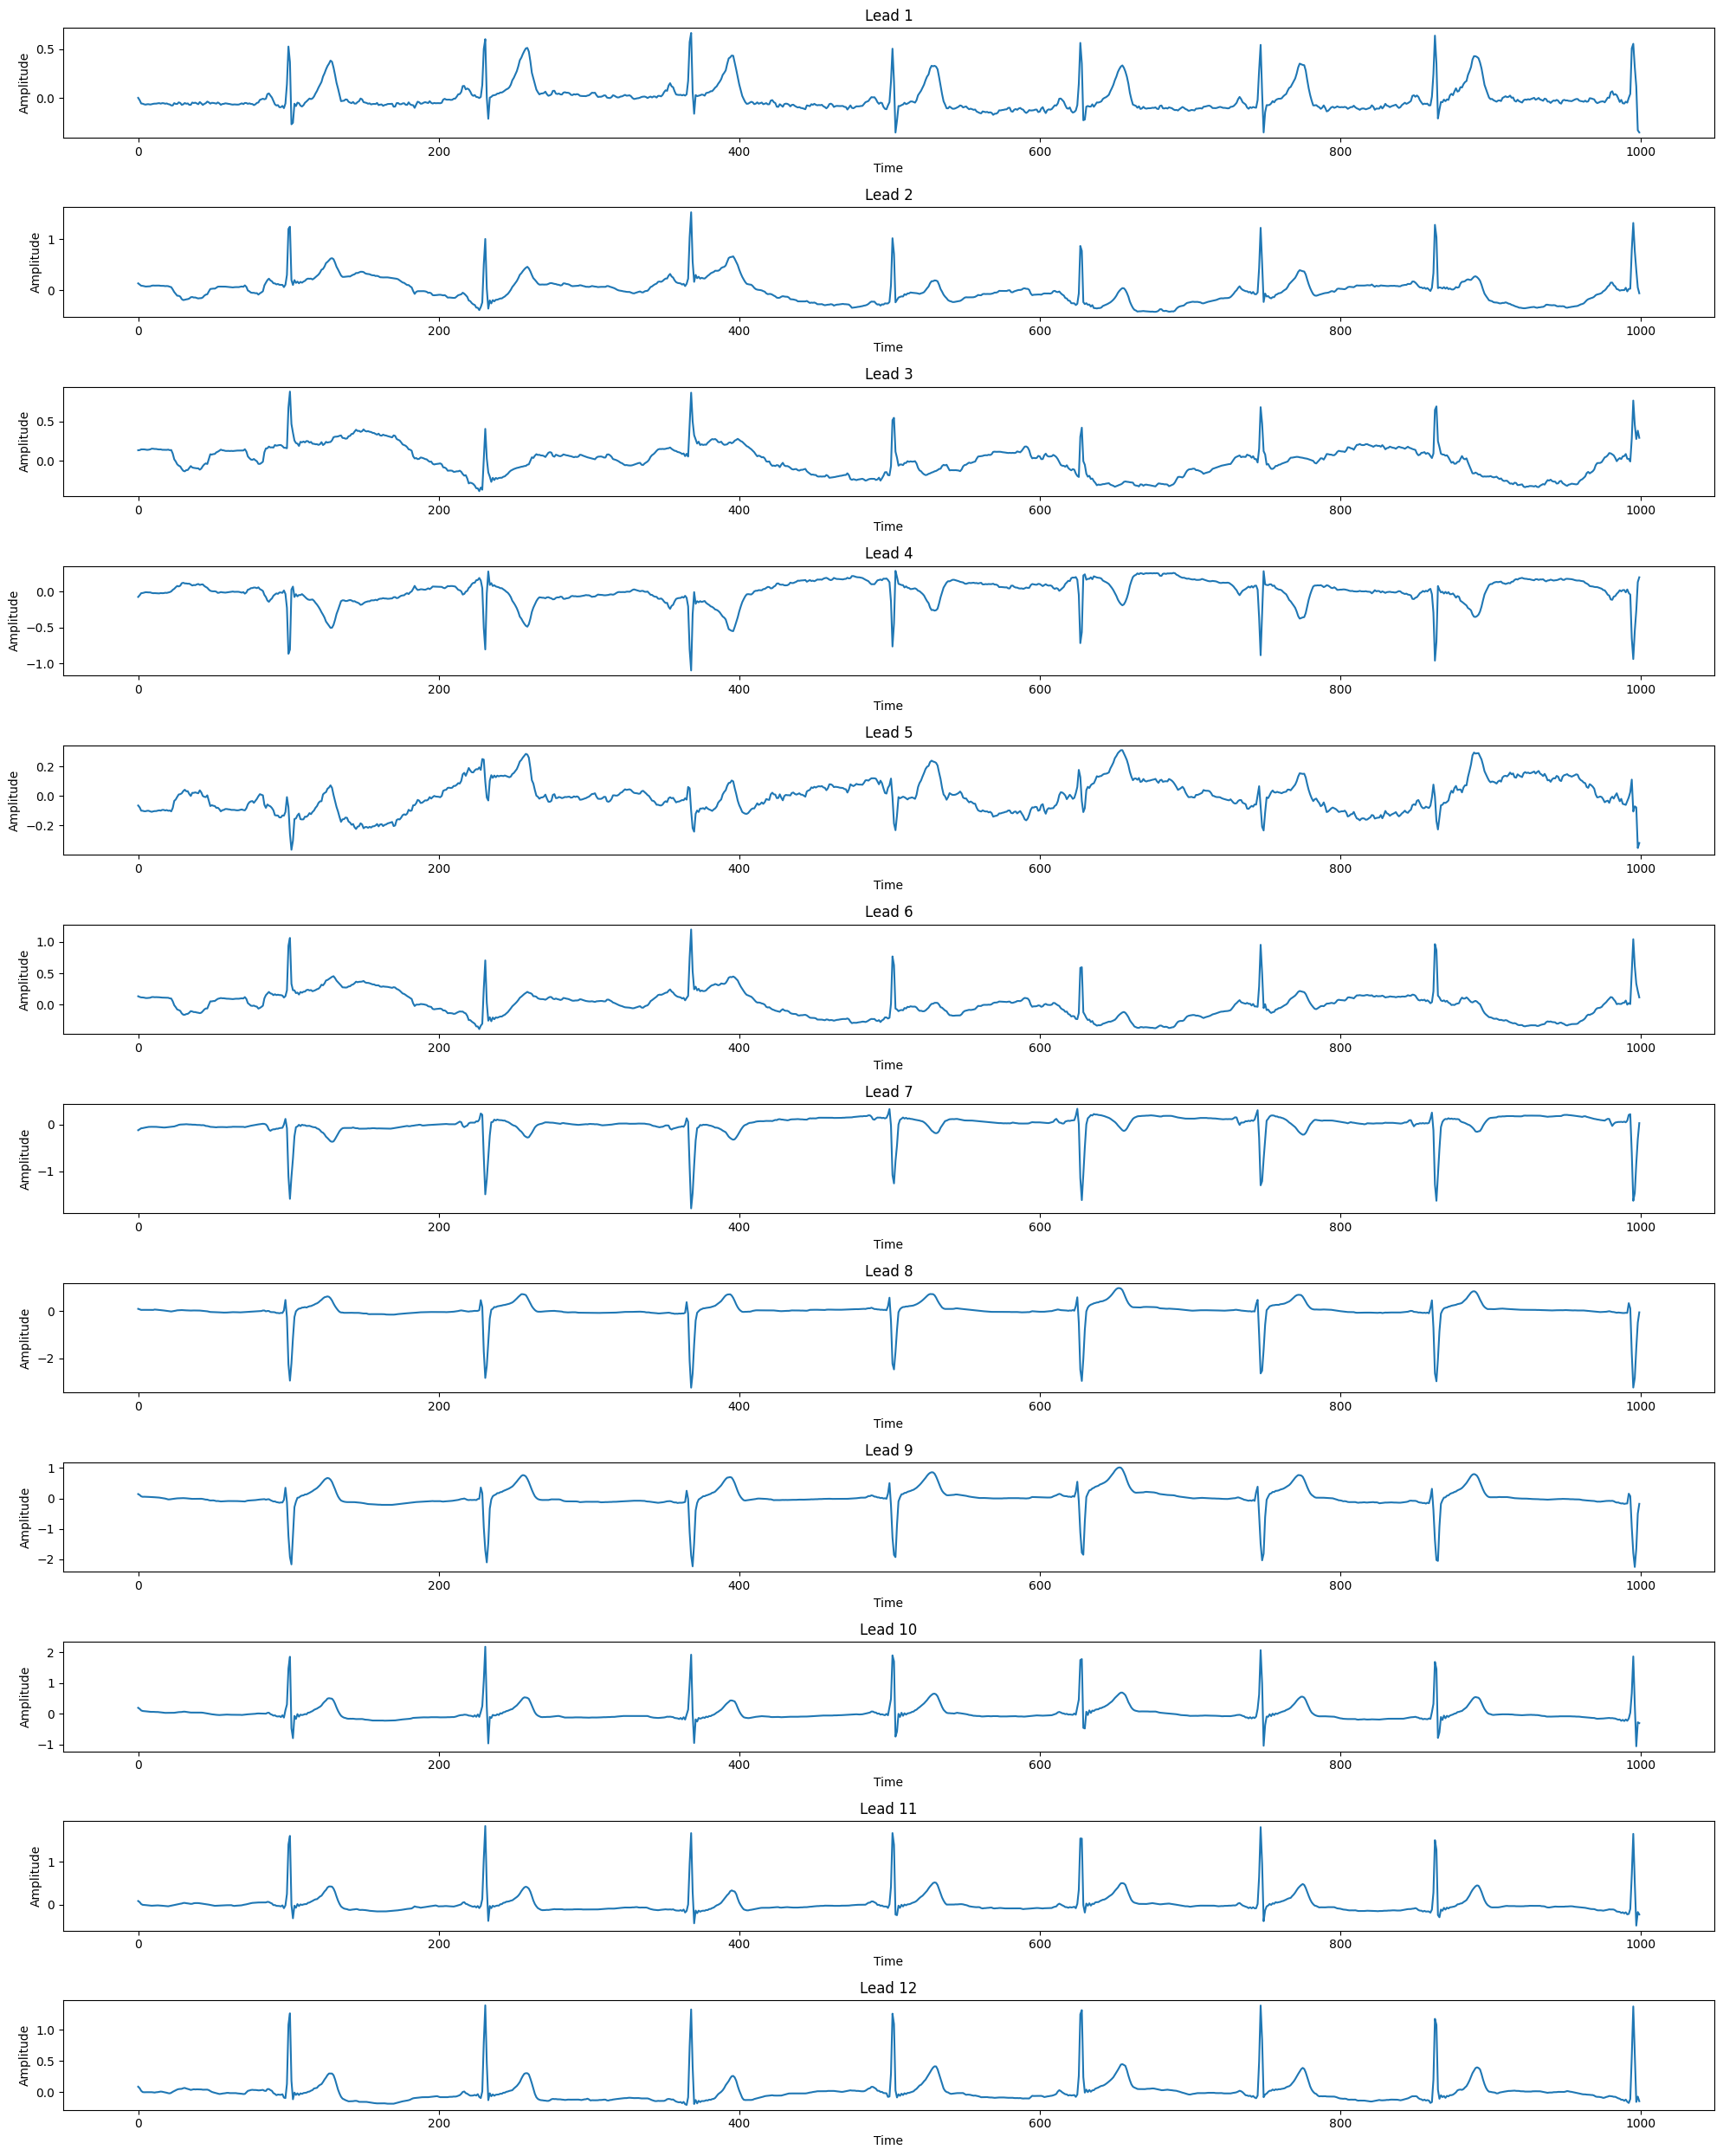

In [14]:

# Generate a time array (assuming a sampling rate of 1 Hz for simplicity)
time = np.arange(0, len(sample), 1)

# Plot each lead in a single column
plt.figure(figsize=(20, 25))

for lead in range(12):
    plt.subplot(12, 1, lead + 1)
    plt.plot(time, sample[:, lead])
    plt.title(f'Lead {lead + 1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Rpeaks: [ 23  46  73  98 230 367 503 626 745 861 993]
RR_intervals: [132, 137, 136, 123, 119, 116, 132]    ave: 127.85714285714286
Beeb per min: 76.71428571428572    freq: 1.2785714285714287


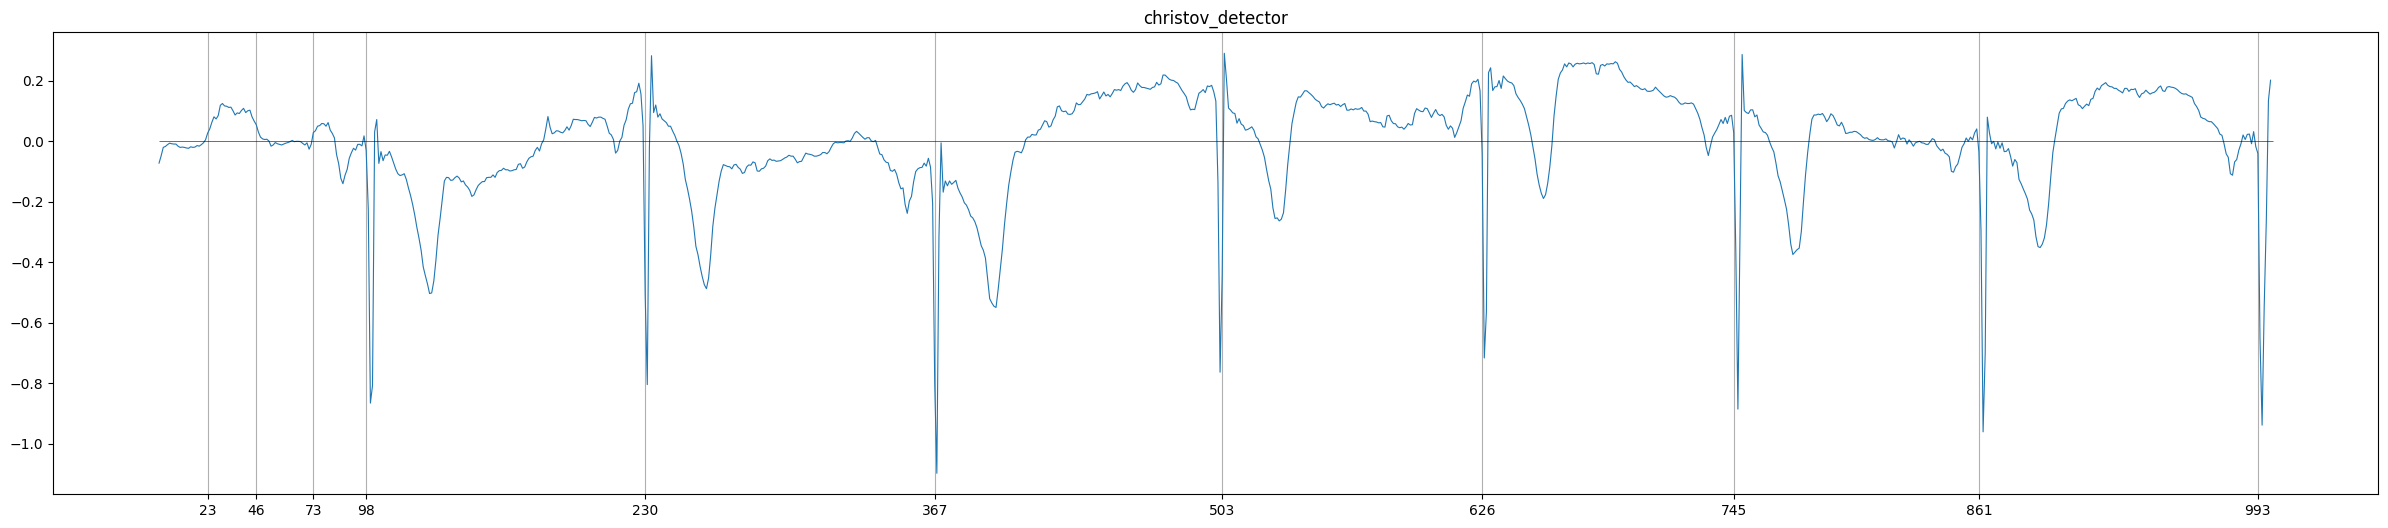

Rpeaks: [ 27  67 103 227 364 505 630 743 866 998]
RR_intervals: [124, 137, 141, 125, 113, 123, 132]    ave: 127.85714285714286
Beeb per min: 76.71428571428572    freq: 1.2785714285714287


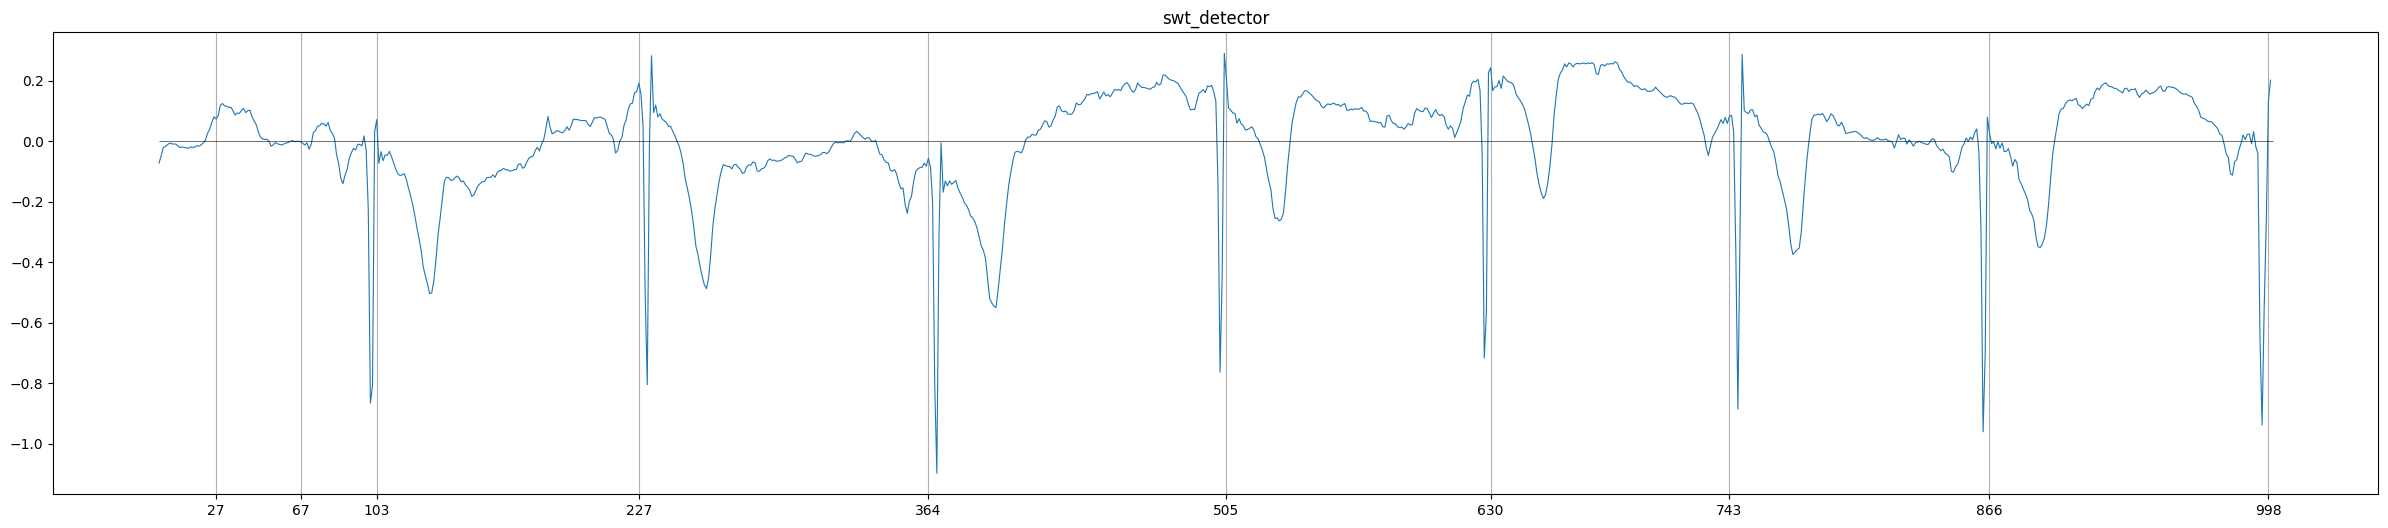

In [15]:
from ecgdetectors import Detectors
BASIC_SRATE = 105#Hz

def remove_outliers(data):
    q1 = np.percentile(data, 35)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_removed = [x for x in data if x >= lower_bound and x <= upper_bound]
    return outliers_removed

detectors = Detectors(BASIC_SRATE)

signal_pad_samples = 10

signal_pad = np.zeros(signal_pad_samples) # pad one sec to detect initial peaks properly
signalf = sample[:,3]
detectors = Detectors(BASIC_SRATE)

detectors = {
#             'pan_tompkins_detector':[detectors.pan_tompkins_detector, []],
#             'hamilton_detector':[detectors.hamilton_detector, []],
            'christov_detector':[detectors.christov_detector, []],   #the best 
#             'engzee_detector':[detectors.engzee_detector, []],
            'swt_detector':[detectors.swt_detector, []],             #the best
#             'two_average_detector':[detectors.two_average_detector, []],
            }


for kd in detectors.keys():
    vd = detectors[kd]
    r_peaks = np.array(vd[0](np.hstack((signal_pad,signalf)))) - signal_pad_samples
    diffs = np.diff( np.array(r_peaks))
    diffs_clean = remove_outliers(diffs )
    aves = np.mean(diffs_clean)
    print( 'Rpeaks:' ,r_peaks )
    print( 'RR_intervals:' ,diffs_clean , '   ave:' , aves )
    print( 'Beeb per min:' ,aves/100*60, '   freq:', aves/100)
    vd[1] = r_peaks
    plt.figure(figsize=(30,6))
    plt.title(kd)
    plt.plot(signalf,color='tab:blue',linewidth=0.8)
    plt.hlines(0,0,1000,color='black', linewidth=0.4)
    plt.xticks(r_peaks)
    plt.grid(axis='x')
    plt.show()

Top frequencies in Lead 1: [ 8.  2.  1. 30.  7.] Hz
Magnitudes: [40.45937584 21.31887373 20.06050147 17.39992675 16.83370082]
Top frequencies in Lead 2: [4. 8. 1. 3. 7.] Hz
Magnitudes: [67.43762402 65.77689323 62.15964646 39.56712475 38.80731734]
Top frequencies in Lead 3: [4. 3. 7. 5. 1.] Hz
Magnitudes: [65.44051514 49.03112387 45.02470529 44.56243688 43.08152319]
Top frequencies in Lead 4: [8. 1. 4. 2. 7.] Hz
Magnitudes: [52.88640931 40.91589254 34.93824174 23.62672835 19.72392902]
Top frequencies in Lead 5: [4. 3. 7. 5. 9.] Hz
Magnitudes: [31.92551907 29.28423414 27.94598088 25.56902951 16.37882688]
Top frequencies in Lead 6: [4. 1. 8. 3. 5.] Hz
Magnitudes: [66.33634749 52.47622018 46.11125699 44.26000457 41.49095908]
Top frequencies in Lead 7: [ 8.  1.  4. 30. 38.] Hz
Magnitudes: [44.64564024 36.01292309 30.51608496 28.56558043 27.69919408]
Top frequencies in Lead 8: [ 8. 16. 25. 22. 17.] Hz
Magnitudes: [69.3479163  68.86488618 59.54990051 57.99399296 54.65860307]
Top frequencies i

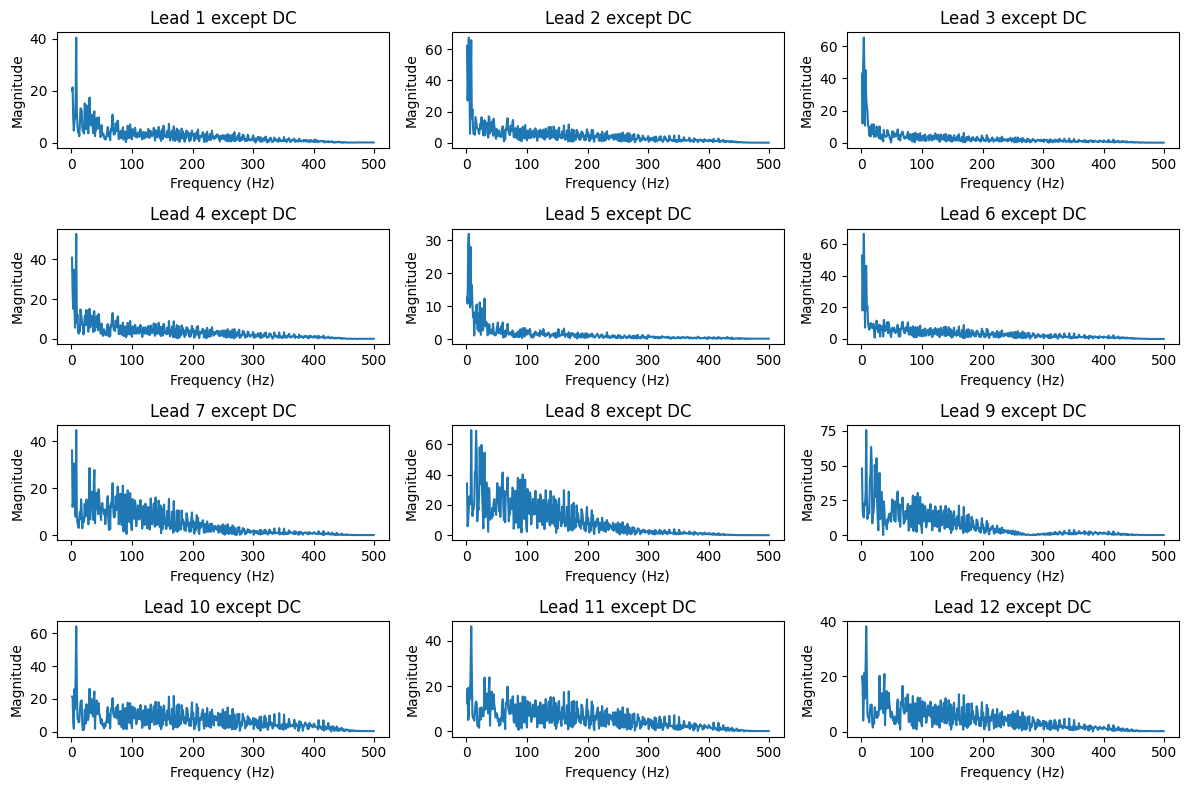

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# Generate a sample ECG signal (replace this with your actual ECG data)
# ecg_signal = np.random.rand(1000, 12)

# Function to compute and plot the Fourier Transform
def plot_fourier_transform(ecg_signal, sample_rate=1000, num_top_frequencies=5):
    # Compute the Fourier Transform
    fft_result = np.fft.fft(ecg_signal, axis=0)
    
    # Frequency axis
    freq_axis = np.fft.fftfreq(ecg_signal.shape[0], d=1/sample_rate)
    
    # Plot the magnitude spectrum for each lead
    plt.figure(figsize=(12, 8))
    for lead in range(ecg_signal.shape[1]):
        plt.subplot(4, 3, lead + 1)
        magnitude_spectrum = np.abs(fft_result[:ecg_signal.shape[0] // 2, lead])
        plt.plot(freq_axis[1:ecg_signal.shape[0] // 2], magnitude_spectrum[1:])
        plt.title(f'Lead {lead + 1} except DC')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        
        # Find the top frequencies and their magnitudes
        top_frequencies_index = np.argsort(magnitude_spectrum)[::-1][:num_top_frequencies]
        top_frequencies = freq_axis[top_frequencies_index]
        top_magnitudes = magnitude_spectrum[top_frequencies_index]
        print(f'Top frequencies in Lead {lead + 1}: {top_frequencies} Hz')
        print(f'Magnitudes: {top_magnitudes}')
    
    plt.tight_layout()
    plt.show()

# Plot the Fourier Transform and identify top frequencies with magnitudes
plot_fourier_transform(sample)


(1000, 12)


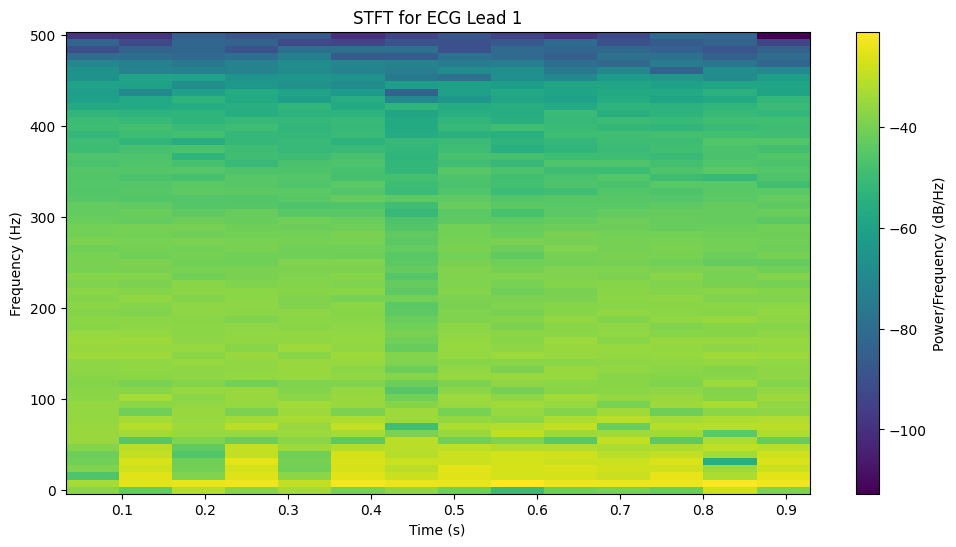

(array([0.064, 0.128, 0.192, 0.256, 0.32 , 0.384, 0.448, 0.512, 0.576,
        0.64 , 0.704, 0.768, 0.832, 0.896]),
 array([  0.    ,   7.8125,  15.625 ,  23.4375,  31.25  ,  39.0625,
         46.875 ,  54.6875,  62.5   ,  70.3125,  78.125 ,  85.9375,
         93.75  , 101.5625, 109.375 , 117.1875, 125.    , 132.8125,
        140.625 , 148.4375, 156.25  , 164.0625, 171.875 , 179.6875,
        187.5   , 195.3125, 203.125 , 210.9375, 218.75  , 226.5625,
        234.375 , 242.1875, 250.    , 257.8125, 265.625 , 273.4375,
        281.25  , 289.0625, 296.875 , 304.6875, 312.5   , 320.3125,
        328.125 , 335.9375, 343.75  , 351.5625, 359.375 , 367.1875,
        375.    , 382.8125, 390.625 , 398.4375, 406.25  , 414.0625,
        421.875 , 429.6875, 437.5   , 445.3125, 453.125 , 460.9375,
        468.75  , 476.5625, 484.375 , 492.1875, 500.    ]))

In [17]:
print(sample.shape)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Assuming you have a 12-leads ECG signal with shape (1000, 12)
# You need to replace 'ecg_signal' with your actual ECG signal data

# # Example ECG signal (replace this with your actual data)
# ecg_signal = np.random.rand(1000, 12)

# Constants
sampling_rate = 1000  # Replace with your actual sampling rate

# Function for Short-Time Fourier Transform
def stft_ecg(ecg_lead , window_size= 128):
    f, t, Sxx = spectrogram(ecg_lead, fs=sampling_rate, nperseg=window_size, noverlap=window_size//2, scaling='spectrum')
    return f, t, Sxx

# Apply the transformation for each lead
transformed_signals = []
for lead in range(12):
    f, t, Sxx = stft_ecg(sample[:, lead])
    transformed_signals.append(Sxx)

# Plot the results for the first lead
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10 * np.log10(transformed_signals[0]), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('STFT for ECG Lead 1')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

t, f



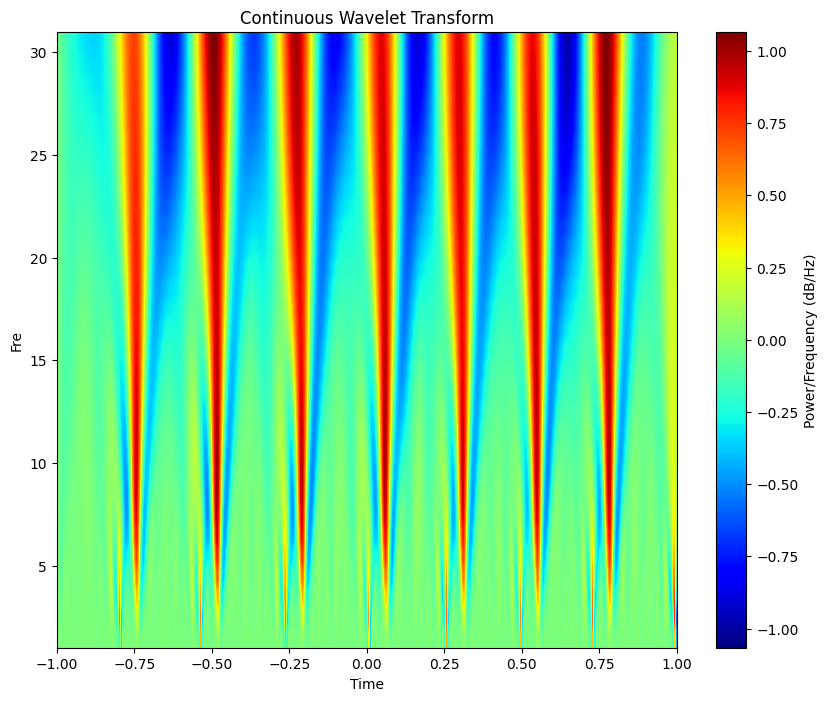

(30, 1000)

In [18]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
# t = np.linspace(-1, 1, 200, endpoint=False)
sig  = sample[:,0] #np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1, 31)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
fig = plt.figure(figsize=(10, 8))

cwtmatr_yflip = np.flipud(cwtmatr)

plt.imshow(cwtmatr_yflip, extent=[-1, 1, 1, 31], cmap='jet', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

# Add labels and title
plt.colorbar(label='Power/Frequency (dB/Hz)')

plt.xlabel('Time')
plt.ylabel('Fre')
plt.title('Continuous Wavelet Transform')


plt.show()
cwtmatr_yflip.shape


In [19]:
# to count the number of uniqe element preventing the dictionaries
ecg_data[[ col for col in ecg_data.columns if col not in ('scp_codes','scp_classes')]].nunique(dropna=True)

sex                       2
height                   59
weight                  102
heart_axis                7
infarction_stadium1       5
infarction_stadium2       3
pacemaker                 4
strat_fold               10
filename_lr            5000
filename_hr            5000
dtype: int64

In [20]:
metaDatas = pd.DataFrame(index=ecg_data.index)


metaDatas['sex'] = ecg_data['sex']

metaDatas['height'] = ecg_data.groupby('sex')['height'].transform(lambda x: x.fillna(x.mean()))

metaDatas['weight'] = ecg_data.groupby('sex')['weight'].transform(lambda x: x.fillna(x.mean()))

metaDatas['infarction_stadium1'] = ecg_data['infarction_stadium1'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

metaDatas['infarction_stadium2'] = ecg_data['infarction_stadium2'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

# 0 represents unknown
metaDatas['heart_axis'] = ecg_data.heart_axis.replace({
    'LAD': 1,
    'ALAD': 2,
    'RAD': 3,
    'AXR': 4,
    'MID': 5,
    'ARAD': 6,
    'AXL': 7,
    'SAG': 8
}).fillna(0)

metaDatas['pacemaker'] = (ecg_data.pacemaker == 'ja, pacemaker').astype(float)

metaDatas

sex      height    weight  infarction_stadium1  infarction_stadium2  \
0       1  161.059371  63.00000                  0.0                  0.0   
1       0  173.774936  70.00000                  0.0                  0.0   
2       1  161.059371  69.00000                  0.0                  0.0   
3       0  173.774936  82.00000                  0.0                  0.0   
4       1  161.059371  70.00000                  0.0                  0.0   
...   ...         ...       ...                  ...                  ...   
4995    0  178.000000  80.00000                  0.0                  0.0   
4996    0  173.774936  78.42707                  0.0                  0.0   
4997    0  173.774936  78.42707                  0.0                  0.0   
4998    0  173.774936  78.42707                  0.0                  0.0   
4999    0  173.774936  78.42707                  0.0                  0.0   

      heart_axis  pacemaker  
0            0.0        0.0  
1            0.0        0.0  
2            0.0        0.0  
3            0.0        0.0  
4            0.0        0.0  
...          ...        ...  
4995         0.0        0.0  
4996         5.0        0.0  
4997         5.0        0.0  
4998         0.0        0.0  
4999         1.0        0.0  

[5000 rows x 7 columns]

In [21]:
signals = ecg_signal
signals.shape

(5000, 1000, 12)

 core components are scp_codes (SCP-ECG statements as a dictionary with entries of the form statement: likelihood, where likelihood is set to 0 if unknown) and report (report string). 

In [22]:
# convert to oneHot

labels = pd.DataFrame( 0 , index= ecg_data.index, columns= ['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype= 'int')

for i in labels.index:  # iterate on labels dataset rows
    for j in ecg_data.loc[i, 'scp_classes']: # choose one of the lables columns base on ecg_data value
        labels.loc[i,j] = 1

# labels['NORM'] = labels['NORM'].fillna(0)
labels

NORM  MI  STTC  CD  HYP
0        1   0     0   0    0
1        1   0     0   0    0
2        1   0     0   0    0
3        1   0     0   0    0
4        1   0     0   0    0
...    ...  ..   ...  ..  ...
4995     1   0     0   0    0
4996     0   0     0   1    0
4997     0   1     1   0    0
4998     0   0     1   0    1
4999     1   0     0   0    0

[5000 rows x 5 columns]

# Splitting the data¶


In [23]:
X_train = metaDatas[ecg_data.strat_fold <= 8]
Y_train = signals[ecg_data[ecg_data.strat_fold <= 8].index - 1]
Z_train = labels[ecg_data.strat_fold <= 8]

X_val = metaDatas[ecg_data.strat_fold == 9]
Y_val = signals[ecg_data[ecg_data.strat_fold == 9].index - 1]
Z_val = labels[ecg_data.strat_fold == 9]

X_test = metaDatas[ecg_data.strat_fold == 10]
Y_test = signals[ecg_data[ecg_data.strat_fold == 10].index - 1]
Z_test = labels[ecg_data.strat_fold == 10]

# ensure shapes match
print(f'X_train: {X_train.shape} Y_train: {Y_train.shape} Z_train: {Z_train.shape}')
print(f'X_val: {X_val.shape} Y_val: {Y_val.shape} Z_val: {Z_val.shape}')
print(f'X_test: {X_test.shape} Y_test: {Y_test.shape} Z_test: {Z_test.shape}')

X_train: (3769, 7) Y_train: (3769, 1000, 12) Z_train: (3769, 5)
X_val: (608, 7) Y_val: (608, 1000, 12) Z_val: (608, 5)
X_test: (623, 7) Y_test: (623, 1000, 12) Z_test: (623, 5)


# Scaling the data¶


In [24]:

# Scaling X
X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Scaling Y
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))
Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_val_scaled = Y_scaler.transform(Y_val.reshape(-1, Y_val.shape[-1])).reshape(Y_val.shape)
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

In [28]:



root_path = './ptb-xl-dataset-1.0.3/'

# library designed to provide tools for performing parallel computing and efficient data processing
# joblib.dump(X_train_scaled, root_path + 'X_train_scaled.joblib')
# joblib.dump(Y_train_scaled, root_path + 'Y_train_scaled.joblib')
# joblib.dump(Z_train, root_path + 'Z_train.joblib')
# joblib.dump(X_test_scaled, root_path + 'X_test_scaled.joblib')
# joblib.dump(Y_test_scaled, root_path + 'Y_test_scaled.joblib')
# joblib.dump(Z_test, root_path + 'Z_test.joblib')
# joblib.dump(X_val_scaled, root_path + 'X_val_scaled.joblib')
# joblib.dump(Y_val_scaled, root_path + 'Y_val_scaled.joblib')
# joblib.dump(Z_val, root_path + 'Z_val.joblib')

X_train_scaled = joblib.load(root_path + 'X_train_scaled.joblib')
Y_train_scaled = joblib.load(root_path + 'Y_train_scaled.joblib')
Z_train = joblib.load(root_path + 'Z_train.joblib')

X_val_scaled = joblib.load(root_path + 'X_val_scaled.joblib')
Y_val_scaled = joblib.load(root_path + 'Y_val_scaled.joblib')
Z_val = joblib.load(root_path + 'Z_val.joblib')

X_test_scaled = joblib.load(root_path + 'X_test_scaled.joblib')
Y_test_scaled = joblib.load(root_path + 'Y_test_scaled.joblib')
Z_test = joblib.load(root_path + 'Z_test.joblib')


# FREQ Model


In [29]:
# X_train_scaled.shape
# # type(X_train_scaled)

num_data = 5000
num_valtes = int(num_data/5)
num_channel = 12
X_train_scaled = X_train_scaled[:num_data]
Y_train_scaled = Y_train_scaled[:num_data,:,:num_channel]
Z_train = Z_train[:num_data]

X_val_scaled = X_val_scaled[:num_valtes]
Y_val_scaled = Y_val_scaled[:num_valtes,:,:num_channel]
Z_val = Z_val[:num_valtes]

X_test_scaled = X_test_scaled[:num_valtes]
Y_test_scaled = Y_test_scaled[:num_valtes,:,:num_channel]
Z_test = Z_test[:num_valtes]

print(f'X_train: {X_train_scaled.shape} Y_train: {Y_train_scaled.shape} Z_train: {Z_train.shape}')
print(f'X_val: {X_val_scaled.shape} Y_val: {Y_val_scaled.shape} Z_val: {Z_val.shape}')
print(f'X_test: {X_test_scaled.shape} Y_test: {Y_test_scaled.shape} Z_test: {Z_test.shape}')

X_train: (5000, 7) Y_train: (5000, 1000, 12) Z_train: (5000, 5)
X_val: (1000, 7) Y_val: (1000, 1000, 12) Z_val: (1000, 5)
X_test: (1000, 7) Y_test: (1000, 1000, 12) Z_test: (1000, 5)


## Is Balanced?

In [30]:
class_counts = np.sum(Z_train, axis=0)

# Print the count of data in each class
for i, count in enumerate(class_counts):
    print(f"Class {i+1}: {count} data points")

Class 1: 2531 data points
Class 2: 983 data points
Class 3: 1144 data points
Class 4: 1087 data points
Class 5: 554 data points


In [19]:


# Define model parameters
input_shape = (1000, num_channel)
num_classes = 5

# Define LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Compile model
adam = optimizers.legacy.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam , metrics=['accuracy'])

# Print model summary
model.summary()

# Train model
model.fit(Y_train_scaled, Z_train, epochs=1, batch_size=512 , validation_split=0.2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                19712     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 26117 (102.02 KB)
Trainable params: 26117 (102.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ResourceExhaustedError: Graph execution error:

Detected at node while/split defined at (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code

  File "C:\Users\ACER\AppData\Local\Temp\ipykernel_22732\1706031692.py", line 35, in <module>

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\base_rnn.py", line 556, in __call__

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\lstm.py", line 749, in call

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\lstm.py", line 1339, in lstm_with_backend_selection

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\lstm.py", line 981, in standard_lstm

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py", line 5168, in rnn

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py", line 5147, in _step

  File "C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\lstm.py", line 971, in step

OOM when allocating tensor with shape[512,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node while/split}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[sequential_1/lstm_1/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6870]

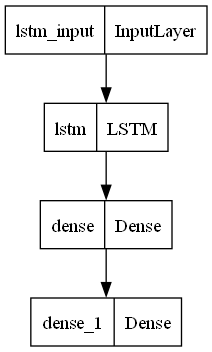

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model)


# FFT & WLT

(129, 9, 6) (2000, 129, 9, 6)


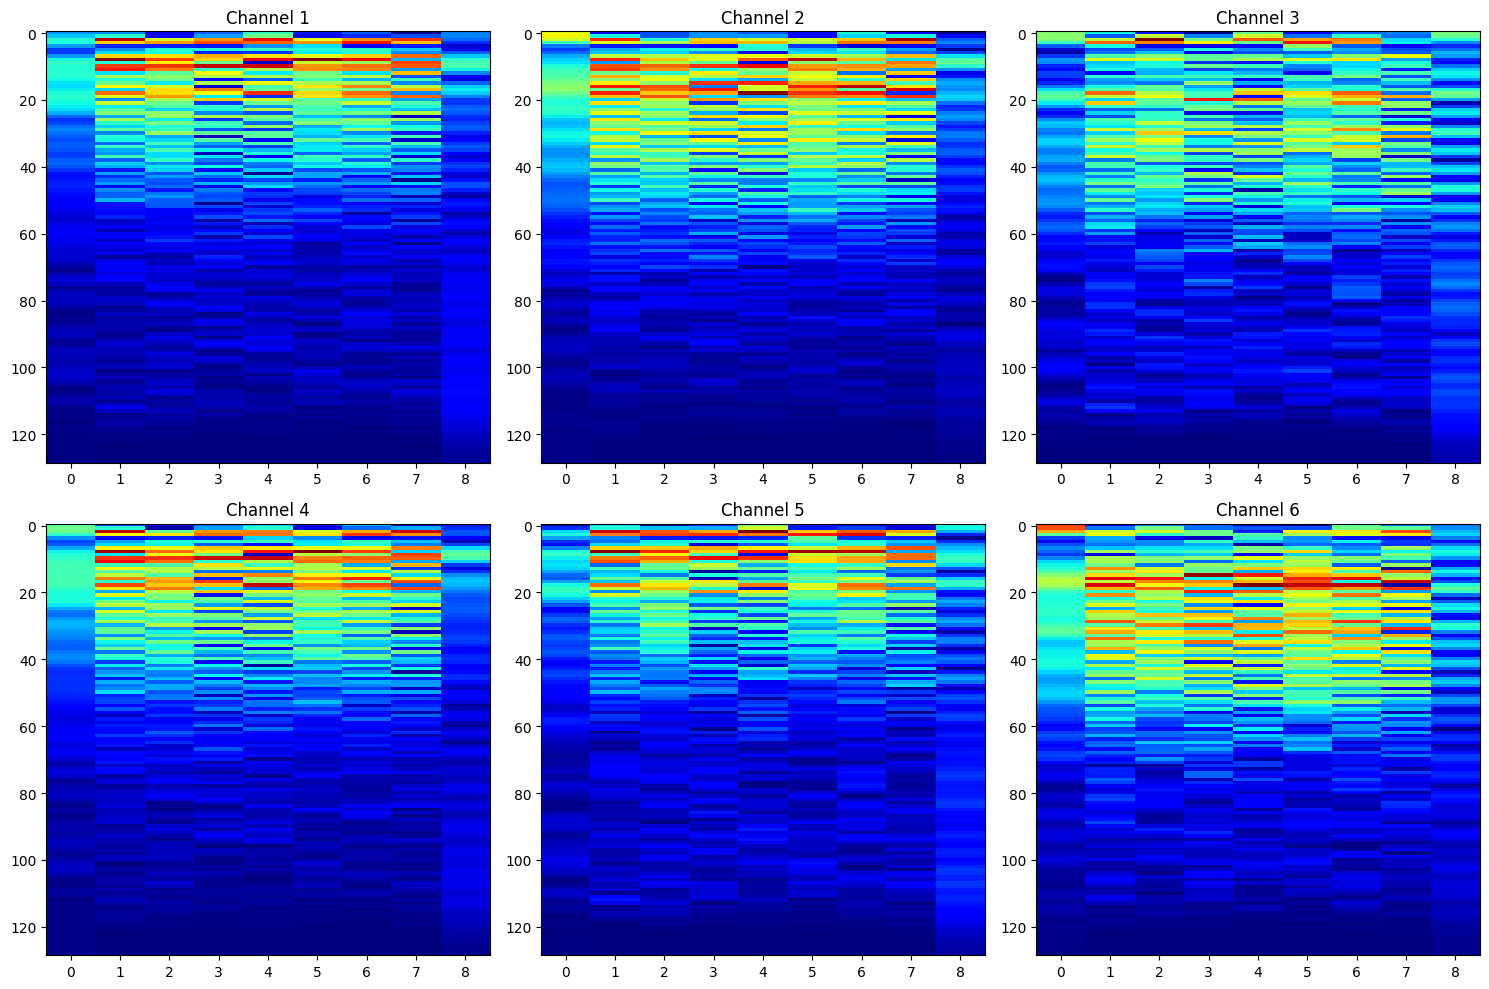

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
X_train = X_train_scaled
X_valid = X_val_scaled
X_test  = X_test_scaled
Y_train = Y_train_scaled
Y_valid = Y_val_scaled
Y_test  = Y_test_scaled
Z_train = Z_train
Z_valid = Z_val
Z_test  = Z_test
# Assuming Y_train is your ECG signals with shape (5000, 1000, 6)
# and Z_train is your labels with shape (5000, 5)

# Define function to compute STFT for a single channel
def compute_stft(signal):
    f, t, Zxx = stft(signal, fs=1000, nperseg=256)
    return np.abs(Zxx)

# Function to compute STFT for all channels and concatenate
def compute_concat_stft(ecg_signals):
    stft_images = []
#     print(ecg_signals.shape)
    for i in range(ecg_signals.shape[1]):  # Loop through channels
        channel_stft = compute_stft(ecg_signals[ :, i])
        stft_images.append(channel_stft)
    return np.stack(stft_images, axis=2)

# Compute STFT for all subjects
stft_images = []
for i in range(Y_train.shape[0]):  # Loop through subjects
    subject_stft = compute_concat_stft(Y_train[i])
    stft_images.append(subject_stft)
stft_images = np.stack(stft_images, axis=0)

print( subject_stft.shape , stft_images.shape )

# Plot STFT images for the first subject
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(stft_images.shape[3]):
    ax = axs[i // 3, i % 3]
    ax.imshow(stft_images[0, :, :, i], aspect='auto', cmap='jet')
    ax.set_title(f'Channel {i+1}')
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model


# Assuming stft_images is your input data with shape (5000, 129, 9, 6)
# and Z_train is your labels with shape (5000, 5)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(stft_images, Z_train, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(129, 9, 6)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001) ),
#     BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001) ),
    keras.layers.Dropout(0.2, name='Z_drop_1'),
#     BatchNormalization(),

    Dense(5, activation='softmax')  # Assuming 5 classes for classification
])

# Compile the model
adam = optimizers.legacy.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000003)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')


Epoch 1/30
7/7 [==============================] - 3s 173ms/step - loss: 0.7225 - accuracy: 0.2556 - val_loss: 0.7218 - val_accuracy: 0.2075
Epoch 2/30
7/7 [==============================] - 1s 104ms/step - loss: 0.7213 - accuracy: 0.3006 - val_loss: 0.7205 - val_accuracy: 0.2775
Epoch 3/30
7/7 [==============================] - 1s 100ms/step - loss: 0.7200 - accuracy: 0.3212 - val_loss: 0.7191 - val_accuracy: 0.3725
Epoch 4/30
7/7 [==============================] - 1s 100ms/step - loss: 0.7188 - accuracy: 0.3575 - val_loss: 0.7177 - val_accuracy: 0.5025
Epoch 5/30
7/7 [==============================] - 1s 100ms/step - loss: 0.7173 - accuracy: 0.4019 - val_loss: 0.7162 - val_accuracy: 0.5300
Epoch 6/30
7/7 [==============================] - 1s 100ms/step - loss: 0.7157 - accuracy: 0.4081 - val_loss: 0.7146 - val_accuracy: 0.5525
Epoch 7/30
7/7 [==============================] - 1s 102ms/step - loss: 0.7142 - accuracy: 0.4338 - val_loss: 0.7129 - val_accuracy: 0.5525
Epoch 8/30
7/7 [====

(1600, 129, 9, 6) (400, 129, 9, 6) (1600, 5) (400, 5)


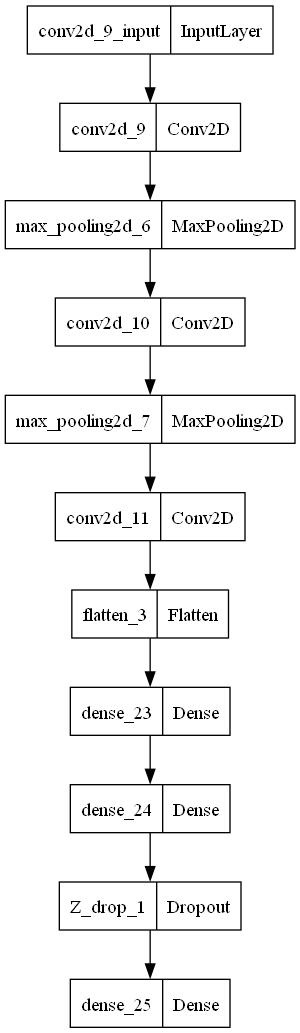

In [15]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
plot_model(model)


In [22]:



X_train = X_train_scaled
X_valid = X_val_scaled
X_test  = X_test_scaled
Y_train = Y_train_scaled
Y_valid = Y_val_scaled
Y_test  = Y_test_scaled
Z_train = Z_train
Z_valid = Z_val
Z_test  = Z_test
# Assuming Y_train is your ECG signals with shape (5000, 1000, 6)
# and Z_train is your labels with shape (5000, 5)

# Define function to compute Wavelet Transform for a single channel
def compute_wavelet_transform(signal):
    coeffs, _ = pywt.cwt(signal, scales=np.arange(1, 129), wavelet='morl')
    return coeffs.T

# Function to compute Wavelet Transform for all channels and concatenate
def compute_concat_wavelet_transform(ecg_signals):
    wavelet_images = []
    for i in range(ecg_signals.shape[1]):  # Loop through channels
        channel_wavelet = compute_wavelet_transform(ecg_signals[ :, i])
        wavelet_images.append(channel_wavelet)
    return np.stack(wavelet_images, axis=2)

# Compute Wavelet Transform for all subjects
wavelet_images = []
for i in range(Y_train.shape[0]):  # Loop through subjects
    subject_wavelet = compute_concat_wavelet_transform(Y_train[i])
    wavelet_images.append(subject_wavelet)
wavelet_images = np.stack(wavelet_images, axis=0)

# Plot Wavelet Transform images for the first subject
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(wavelet_images.shape[3]):
    ax = axs[i // 3, i % 3]
    ax.imshow(wavelet_images[0, :, :, i], aspect='auto', cmap='jet')
    ax.set_title(f'Channel {i+1}')
plt.tight_layout()
plt.show()

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(wavelet_images, Z_train, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 9, 6)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # Assuming 5 classes for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')


MemoryError: Unable to allocate 11.4 GiB for an array with shape (1000, 1000, 128, 12) and data type float64

_________________________________

In [32]:
import keras

X_train = X_train_scaled
X_valid = X_val_scaled
X_test  = X_test_scaled
Y_train = Y_train_scaled
Y_valid = Y_val_scaled
Y_test  = Y_test_scaled
Z_train = Z_train
Z_valid = Z_val
Z_test  = Z_test


def create_X_model(X, *, units=32, dropouts=0.3):
    X = tf.keras.layers.Dense(units, activation='relu', name='X_dense_1')(X)
    X = tf.keras.layers.Dropout(dropouts, name='X_drop_1')(X)
    X = tf.keras.layers.Dense(units, activation='relu', name='X_dense_2')(X)
    X = tf.keras.layers.Dropout(dropouts, name='X_drop_2')(X)
    return X

def create_model01(X_shape, Z_shape):
    X_inputs = keras.Input(X_shape[1:], name='X_inputs')

    X = create_X_model(X_inputs)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=X_inputs, outputs=outputs, name='model01')
    return model

model01 = create_model01(X_train.shape, Z_train.shape)
adam = optimizers.legacy.Adam()#learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model01.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model01.summary()

Model: "model01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X_inputs (InputLayer)       [(None, 7)]               0         
                                                                 
 X_dense_1 (Dense)           (None, 32)                256       
                                                                 
 X_drop_1 (Dropout)          (None, 32)                0         
                                                                 
 X_dense_2 (Dense)           (None, 32)                1056      
                                                                 
 X_drop_2 (Dropout)          (None, 32)                0         
                                                                 
 Z_dense_1 (Dense)           (None, 64)                2112      
                                                                 
 Z_dense_2 (Dense)           (None, 64)                4160

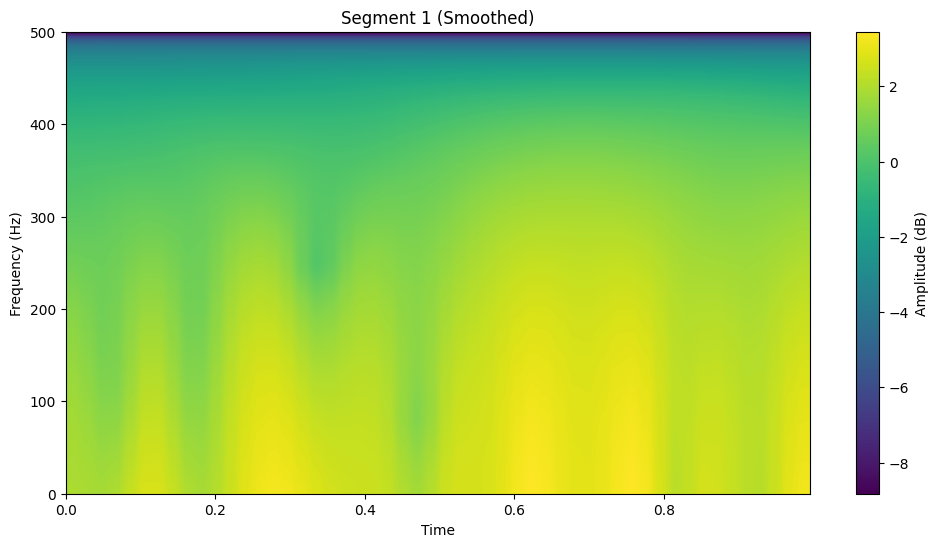

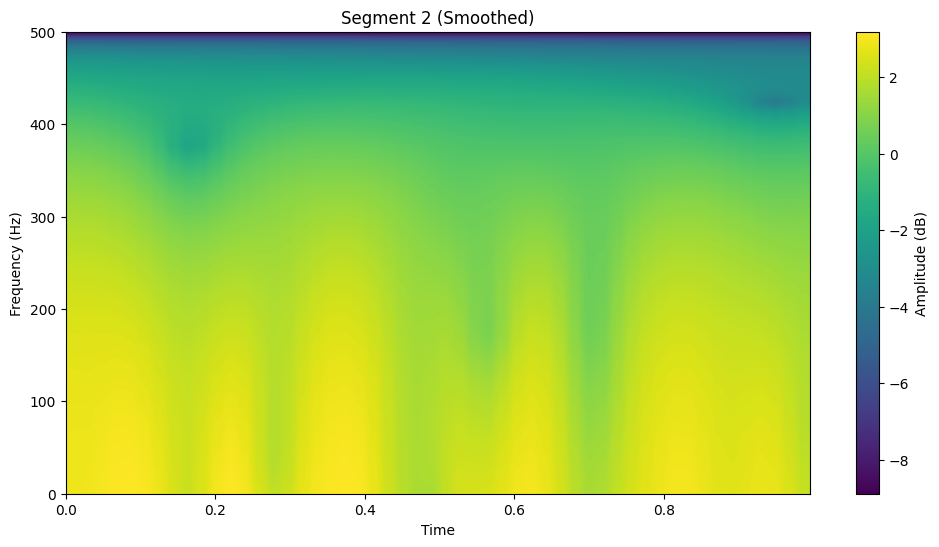

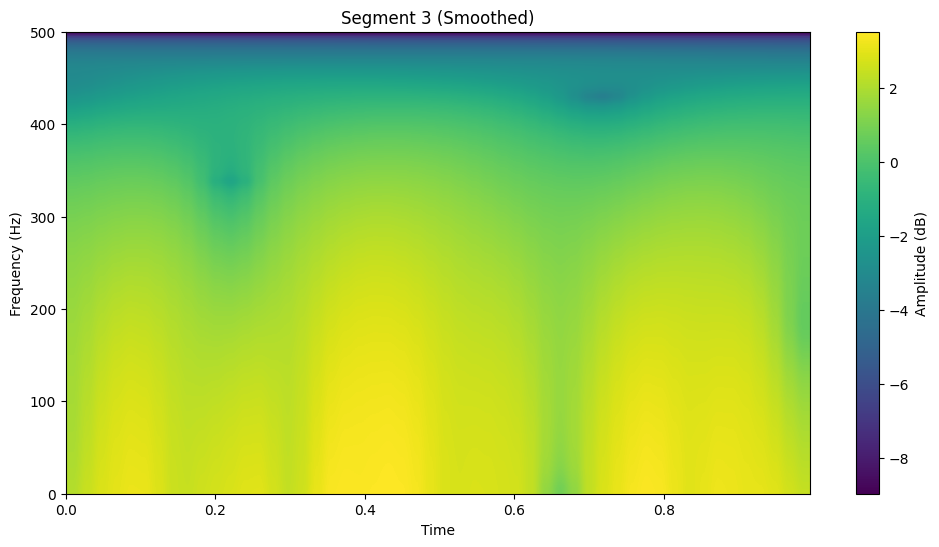

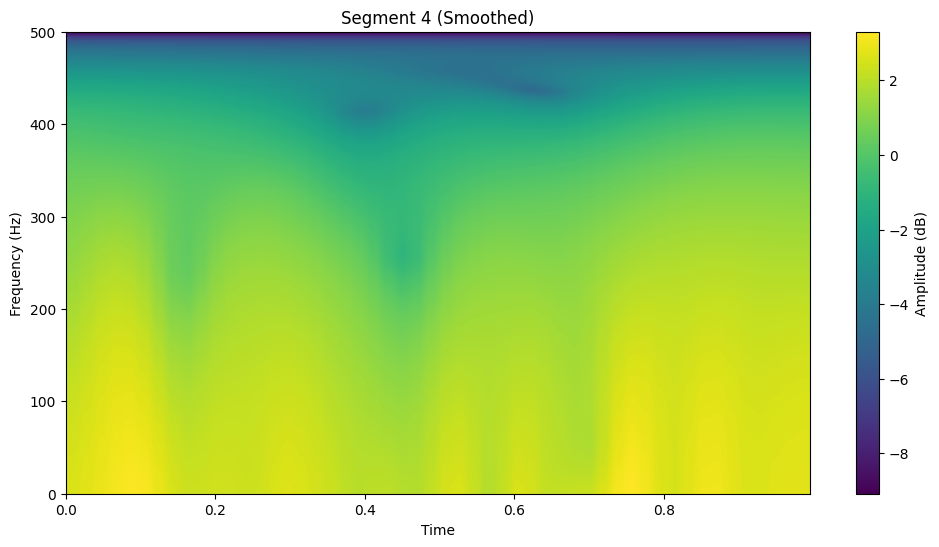

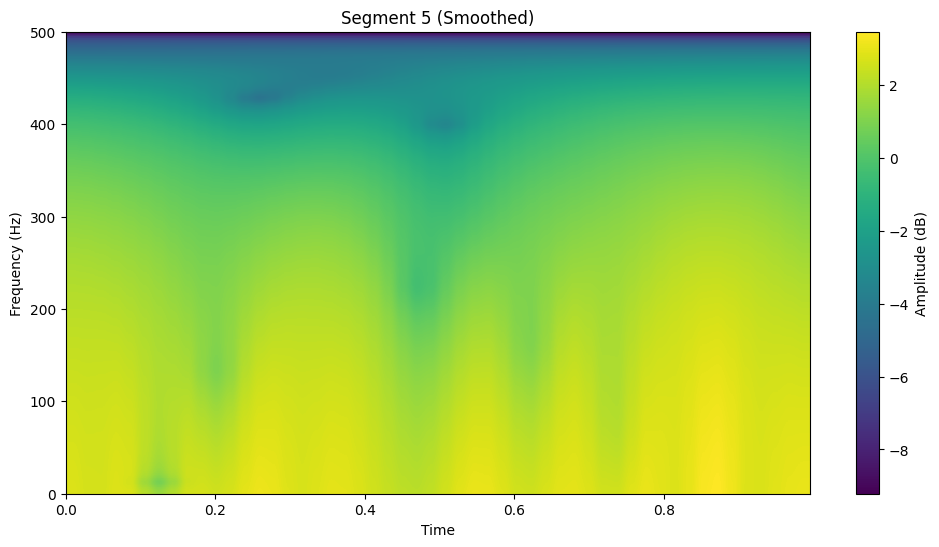

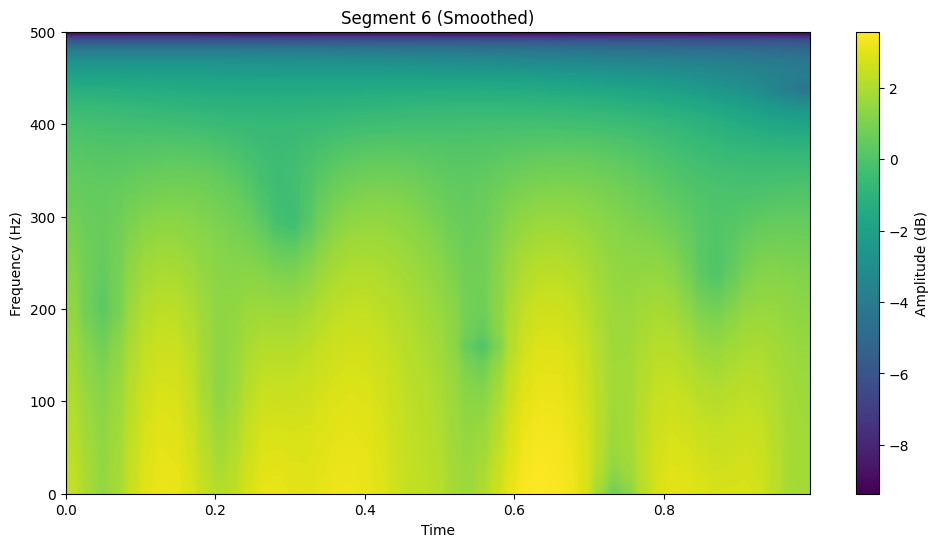

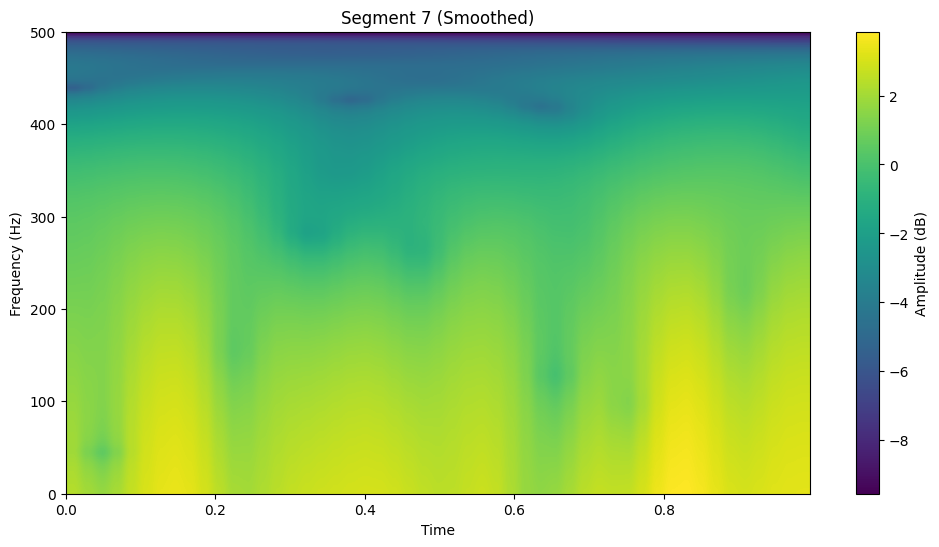

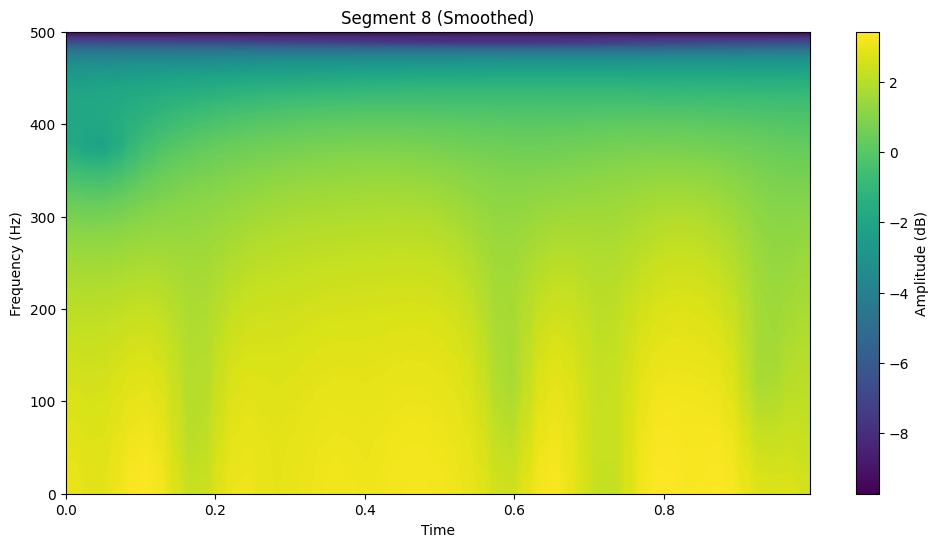

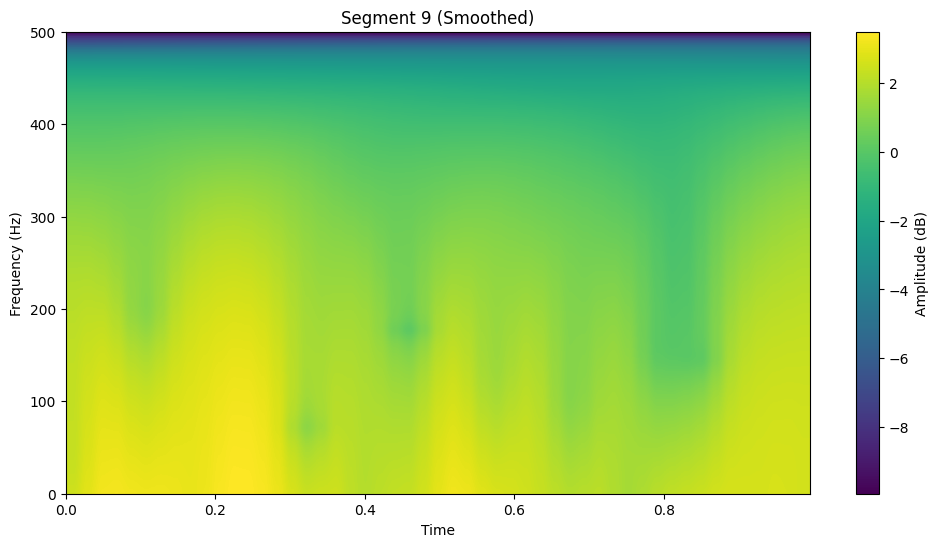

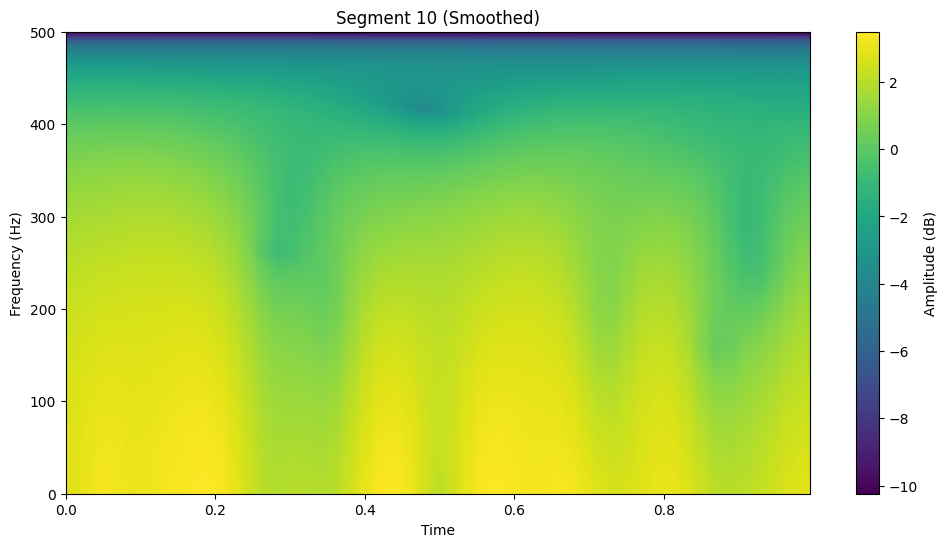

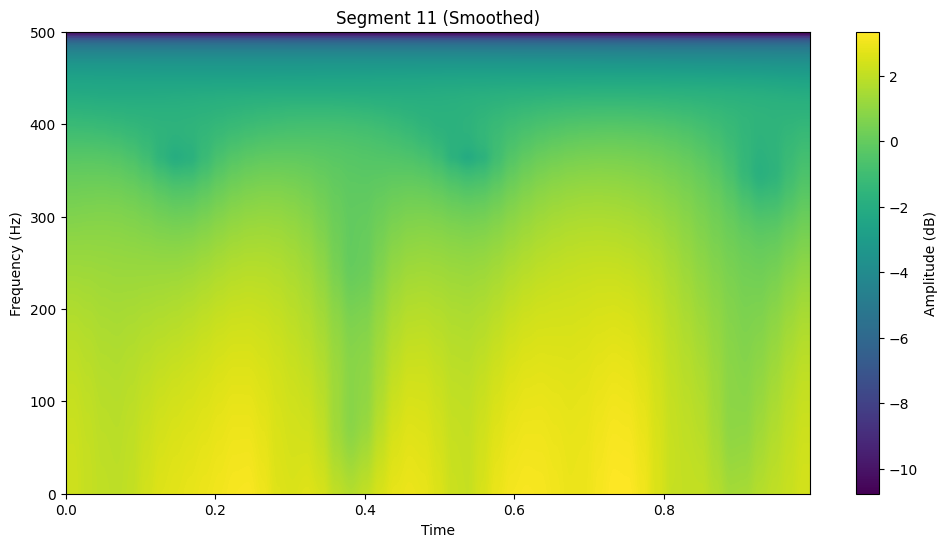

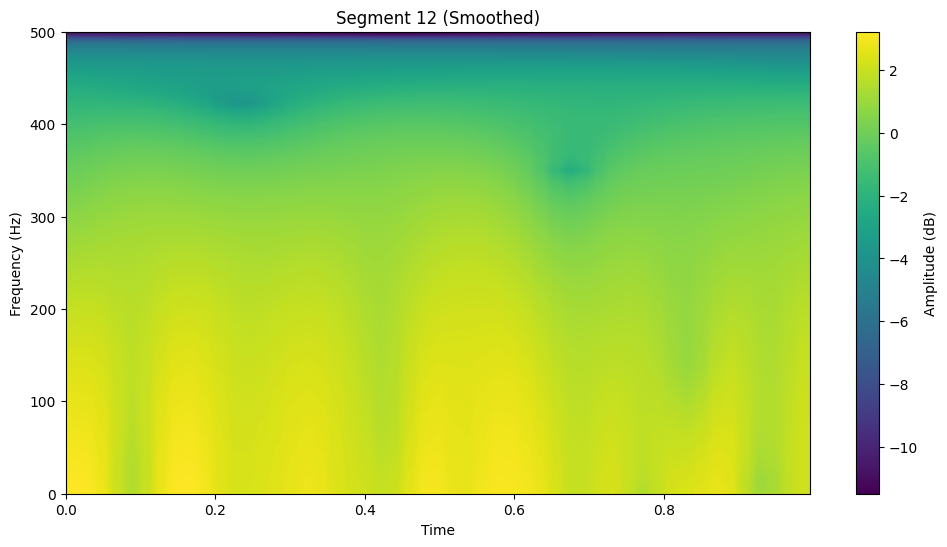

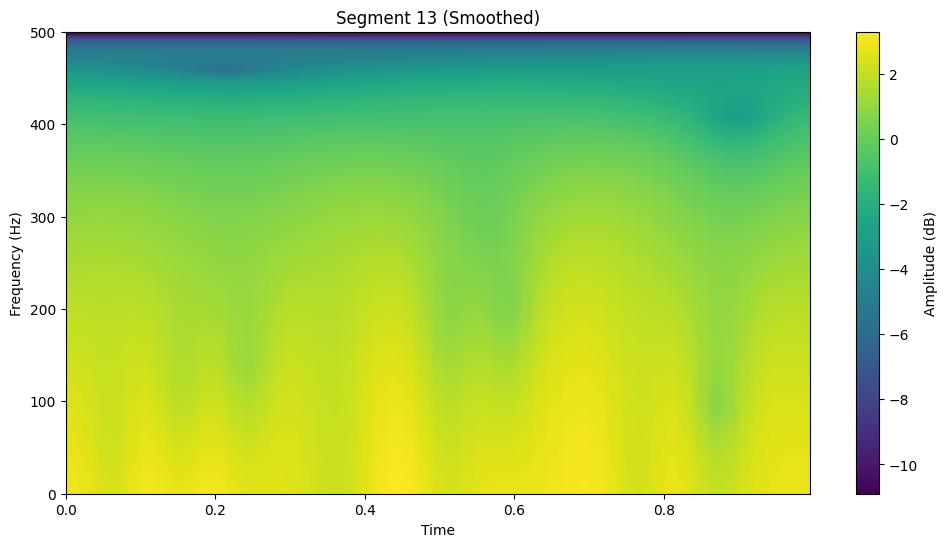

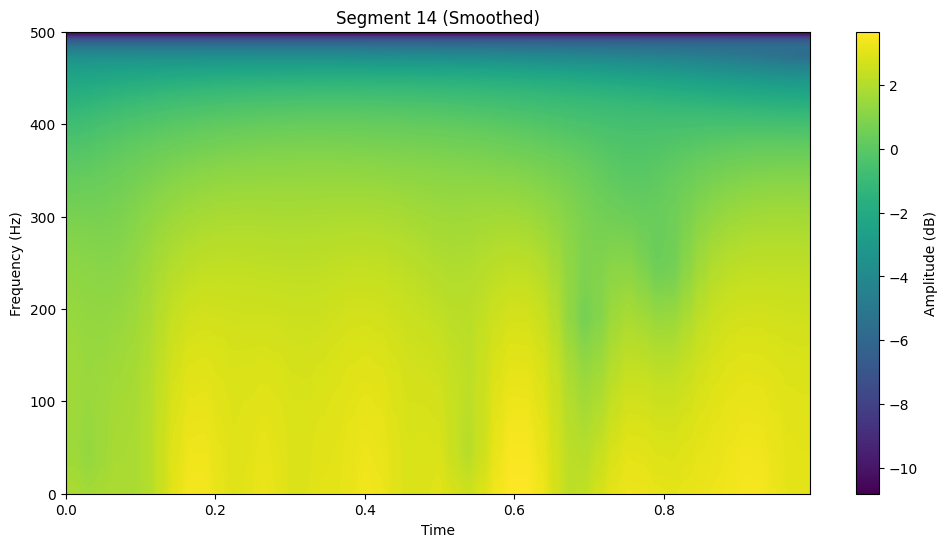

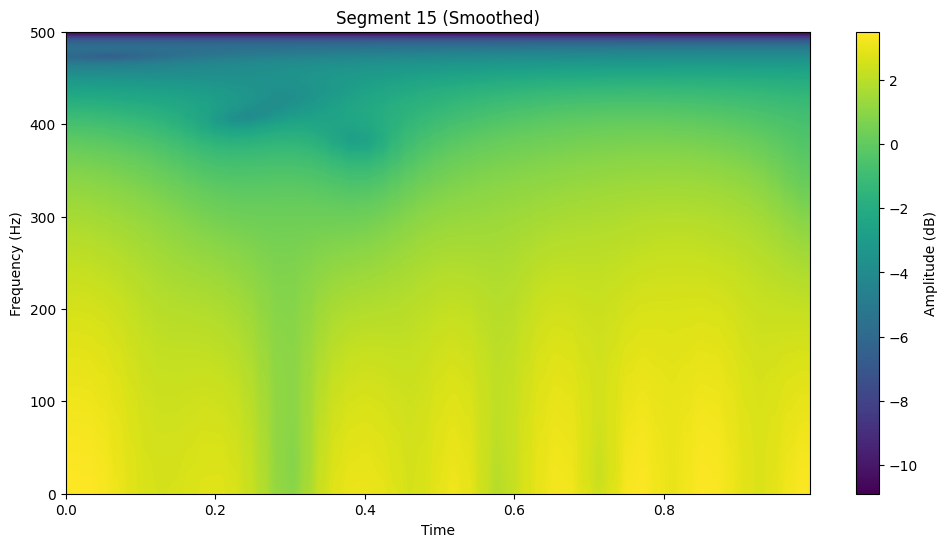

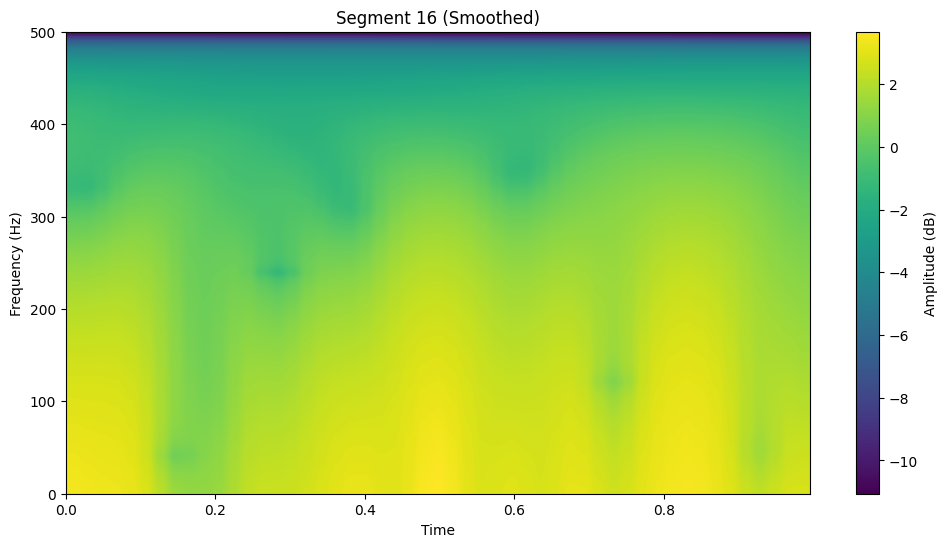

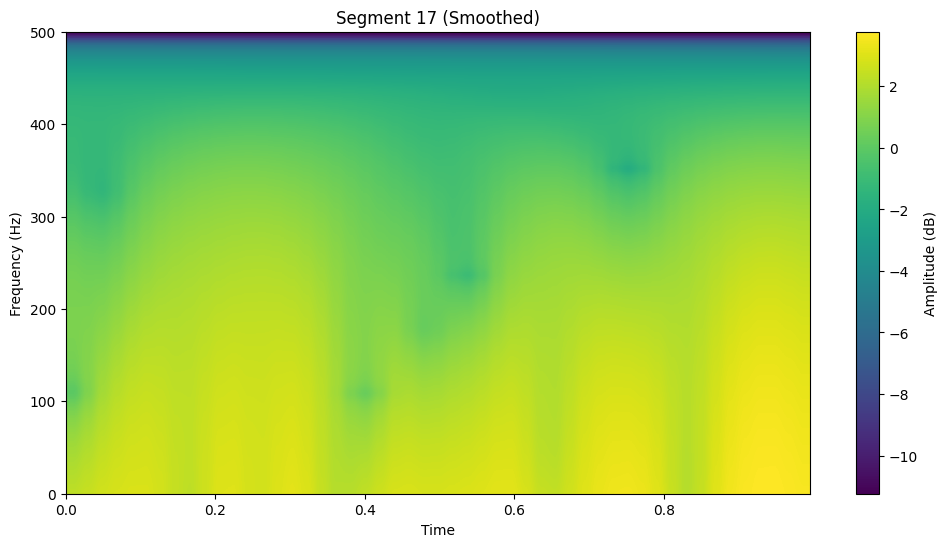

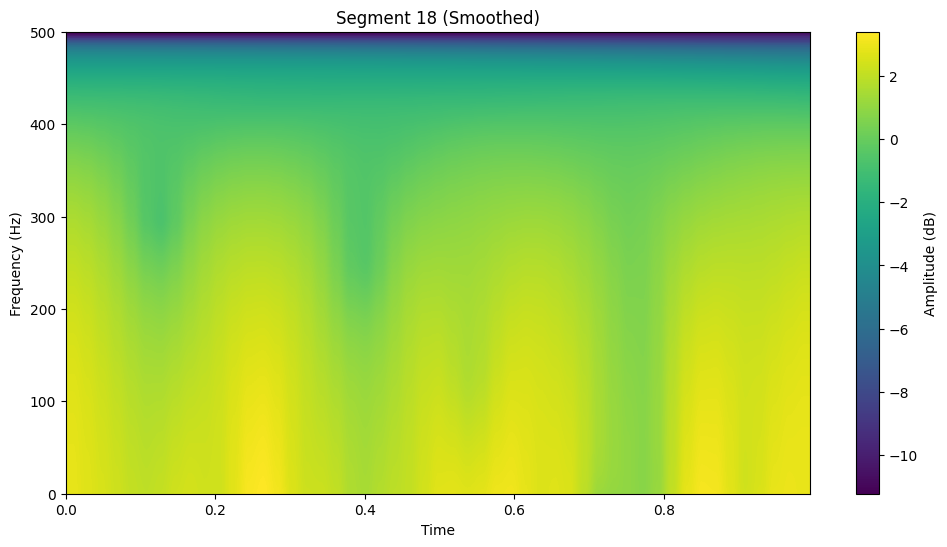

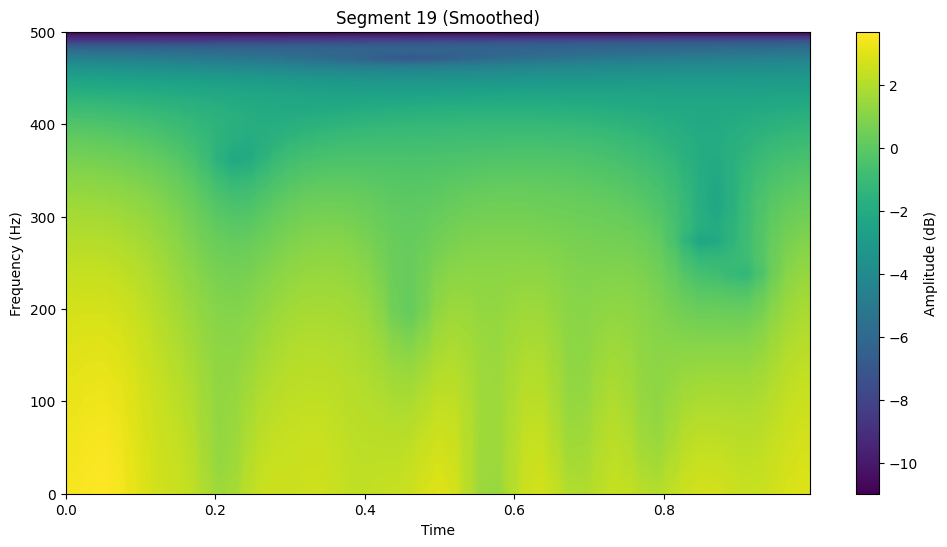

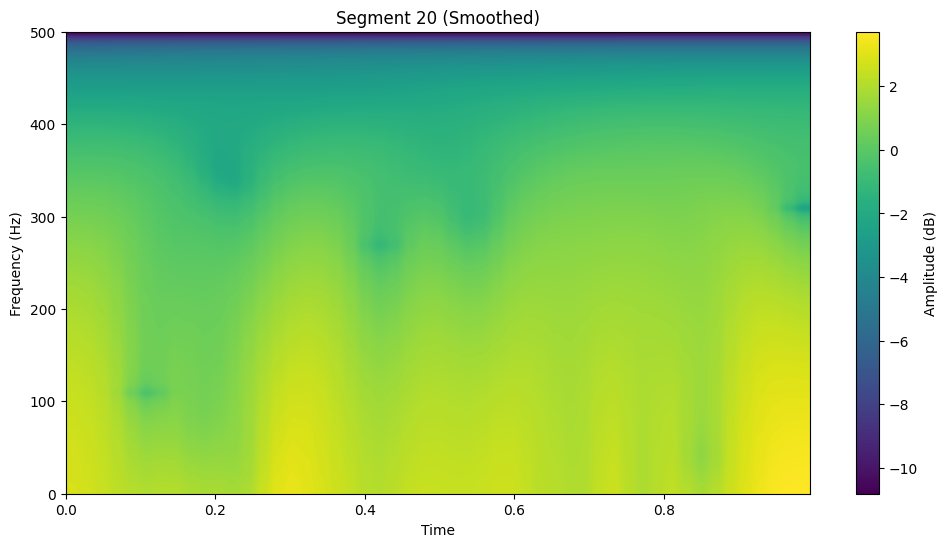

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Example ECG data (replace this with your own data)
example_ecg_data =Y_train #tf.random.normal(shape=(1000,))

# Function to create your Y model (replace this with your actual model)
def create_Y_model(input_shape=(1000, 1), filters=(32, 64)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=filters[0], kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=filters[1], kernel_size=5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


# Parameters for spectrogram computation
win_length = 2000  # Increase the window length for higher frequency resolution
stride = 5  # Decrease the stride for higher time resolution and smoother spectrograms

# Compute the spectrogram using tf.signal.stft
spectrogram = tf.signal.stft(example_ecg_data, frame_length=win_length, frame_step=stride, pad_end=True)

# Get the frequencies and time points
frequencies = np.fft.rfftfreq(win_length, 1.0 / tf.cast(tf.shape(example_ecg_data)[0], tf.float32))
times = np.arange(0, tf.shape(example_ecg_data)[0], stride) / tf.cast(tf.shape(example_ecg_data)[0], tf.float32)

# Compute the magnitude of the spectrogram and convert to dB
spectrogram = tf.abs(spectrogram)
spectrogram = tf.math.log(spectrogram + 1e-6)  # Adding a small value to avoid log(0)

# Convert the spectrogram tensor to a NumPy array and transpose it
spectrogram_array = spectrogram.numpy()

# Compute the extent of the plot using NumPy functions
extent = [times[0], times[-1], frequencies[0], frequencies[-1]]

# Split the spectrogram into multiple smaller images
segment_length = 50  # Number of time points per segment
num_segments = spectrogram_array.shape[1] // segment_length
spectrogram_segments = np.array_split(spectrogram_array, num_segments, axis=1)

# Plot multiple smaller spectrogram images with Gaussian filtering
for i, segment in enumerate(spectrogram_segments):
    # Apply Gaussian filter to the segment
    smoothed_segment = gaussian_filter(segment, sigma=1.0)

    plt.figure(figsize=(12, 6))
    plt.imshow(smoothed_segment, cmap='viridis', aspect='auto', origin='lower', extent=extent)
    plt.colorbar(label='Amplitude (dB)')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Segment {i+1} (Smoothed)')
    plt.show()

In [43]:
Y_train[1:].shape

(4999, 1000, 6)

Model: "model02"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X_inputs (InputLayer)       [(None, 7)]                  0         []                            
                                                                                                  
 X_dense_1 (Dense)           (None, 32)                   256       ['X_inputs[0][0]']            
                                                                                                  
 X_drop_1 (Dropout)          (None, 32)                   0         ['X_dense_1[0][0]']           
                                                                                                  
 X_dense_2 (Dense)           (None, 32)                   1056      ['X_drop_1[0][0]']            
                                                                                            

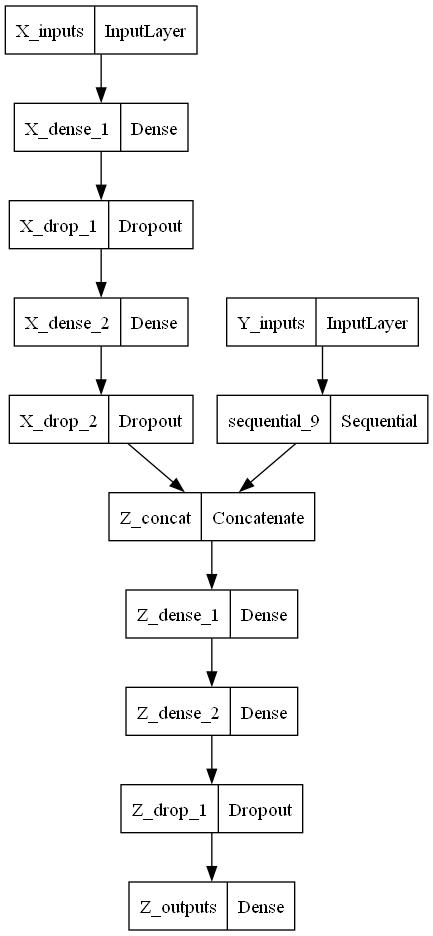

In [39]:
def create_model02(X_shape, Y_shape, Z_shape):
    X_inputs = keras.Input(shape=X_shape[1:], name='X_inputs')
    Y_inputs = keras.Input(shape=Y_shape[1:], name='Y_inputs')

    # Use 2D CNN for Y_inputs
    Y_output = create_Y_model(input_shape=Y_shape[1:], filters=(64, 128))(Y_inputs)

    # Pass X_inputs through the X model
    X = create_X_model(X_inputs)

    # Concatenate the outputs of the X and Y models
    X = keras.layers.Concatenate(name='Z_concat')([X, Y_output])

    X = keras.layers.Dense(64, activation='relu', name='Z_dense_1')(X)
    X = keras.layers.Dense(64, activation='relu', name='Z_dense_2')(X)
    X = keras.layers.Dropout(0.5, name='Z_drop_1')(X)
    outputs = keras.layers.Dense(Z_shape[-1], activation='sigmoid', name='Z_outputs')(X)

    model = keras.Model(inputs=[X_inputs, Y_inputs], outputs=outputs, name='model02')
    return model

model02 = create_model02(X_train.shape, Y_train.shape, Z_train.shape)
adam = optimizers.legacy.Adam()#learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model02.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy', 'Precision', 'Recall'])
model02.summary()

from tensorflow.keras.utils import plot_model
# plt.figure(figsize=(10, 10))

plot_model(model02)
# plt.show()


In [40]:
X_train.shape

(5000, 7)

In [35]:
MODEL_CHECKPOINT = '/kaggle/working/model/model02.keras'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model02.fit([X_train, Y_train], Z_train, epochs=10, batch_size=32, callbacks=callbacks_list, validation_data=([X_valid, Y_valid], Z_valid))

model02 = keras.models.load_model(MODEL_CHECKPOINT)

Epoch 1/10
157/157 [==============================] - 15s 75ms/step - loss: 0.5619 - binary_accuracy: 0.7433 - precision: 0.4805 - recall: 0.2302 - val_loss: 0.5263 - val_binary_accuracy: 0.7518 - val_precision: 0.5465 - val_recall: 0.2492
Epoch 2/10
157/157 [==============================] - 10s 61ms/step - loss: 0.5068 - binary_accuracy: 0.7714 - precision: 0.5853 - recall: 0.3181 - val_loss: 0.5301 - val_binary_accuracy: 0.7544 - val_precision: 0.5344 - val_recall: 0.4074
Epoch 3/10
157/157 [==============================] - 10s 62ms/step - loss: 0.4869 - binary_accuracy: 0.7812 - precision: 0.6045 - recall: 0.3807 - val_loss: 0.5186 - val_binary_accuracy: 0.7558 - val_precision: 0.5387 - val_recall: 0.4028
Epoch 4/10
157/157 [==============================] - 11s 68ms/step - loss: 0.4697 - binary_accuracy: 0.7923 - precision: 0.6447 - recall: 0.3915 - val_loss: 0.5209 - val_binary_accuracy: 0.7590 - val_precision: 0.5571 - val_recall: 0.3426
Epoch 5/10
157/157 [====================

# Torch LSTM

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define model parameters
input_shape = (1000, 12)
num_classes = 5

# Define LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train model
model.fit(Y_train_scaled, Z_train, epochs=50, batch_size=127, validation_split=0.2)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                19712     
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 20037 (78.27 KB)
Trainable params: 20037 (78.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
54/54 [==============================] - 28s 483ms/step - loss: 1.9590 - accuracy: 0.4604 - val_loss: 2.0303 - val_accuracy: 0.4416
Epoch 2/50
54/54 [==============================] - 34s 641ms/step - loss: 1.9174 - accuracy: 0.4981 - val_loss: 2.0311 - val_accuracy: 0.4416
Epoch 3/50
54/54 [==============================] - 43s 797ms/step - loss: 1.9160 - accuracy: 0.4978 - val_loss: 2.0127 - val_ac

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Prepare data
# X_train = np.random.rand(733, 1000, 12)  # Example random data, replace with your actual data
# Y_train = np.random.randint(0, 5, (733, 5))  # Example random labels, replace with your actual labels

# Split data into training and testing sets
X_test = np.array(Y_val_scaled)  
Y_test = np.array(Z_val)
X_train = np.array(Y_train_scaled)
Y_train = np.array(Z_train)
print( X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

# Hyperparameters
input_size = 1
hidden_size = 32
num_layers = 2
num_classes = 5
learning_rate = 0.001
num_epochs = 50
batch_size = 192

# Create dataloaders
train_data = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Initialize model
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store accuracy and loss for plotting
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    
    for i, (signals, labels) in enumerate(train_loader):
        signals = signals.reshape(-1, 1000, 1)
        labels = labels.argmax(dim=1)
        
        # Forward pass
        outputs = model(signals)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track train accuracy and loss
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    # Calculate train accuracy and loss
    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Test the model
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for signals, labels in test_loader:
            signals = signals.reshape(-1, 1000, 1)
            labels = labels.argmax(dim=1)
            
            outputs = model(signals)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_loss += loss.item()

    # Calculate test accuracy and loss
    test_accuracy = 100 * test_correct / test_total
    test_loss /= len(test_loader)

    # Store accuracy and loss for plotting
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # Print train and test accuracy and loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')

print('Training finished')

# Plot train and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


(15833, 1000, 12) (15833, 5) (2074, 1000, 12) (2074, 5)


ValueError: Expected input batch_size (2304) to match target batch_size (192).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMBidirectional(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob):
        super(LSTMBidirectional, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_prob)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 2)  # Adjusted batch norm size
        self.batch_norm2 = nn.BatchNorm1d(64)  # Adjusted batch norm size
        
    def forward(self, x):
        # LSTM layer
        lstm_output, _ = self.lstm(x)

        # Fully connected layers
        x = torch.relu(self.fc1(lstm_output[:, -1, :]))  # Use only the last time step's output
        x = self.dropout(x)
        x = self.batch_norm1(x)  # Adjusted batch norm size
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)  # Adjusted batch norm size
        
        return torch.sigmoid(x)


# Define model parameters
input_size = 1  # Assuming 12 features in the input
hidden_size = 64
num_layers = 1
num_classes = 5  # Assuming 5 output classes
dropout_prob = 0.2

# Create the model instance
model = LSTMBidirectional(input_size, hidden_size, num_layers, num_classes, dropout_prob)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Assuming binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with default parameters
outputs = Y_train
inputs = X_train_scaled

# Train the model (assuming you have train_loader, val_loader, and test_loader)
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    # Validation and/or test evaluation after each epoch
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss = criterion(outputs, targets)
    
    # Print or log the losses, and any other metrics you're interested in

    # Calculate test accuracy and loss
    test_accuracy = 100 * test_correct / test_total
    test_loss /= len(test_loader)

    # Store accuracy and loss for plotting
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # Print train and test accuracy and loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')

print('Training finished')

# Plot train and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot train and test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model CNN1D

In [33]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Dense, Concatenate, GlobalAveragePooling1D, BatchNormalization, ReLU
from keras import callbacks
from tensorflow.keras import optimizers


# X model
X_input = tf.keras.layers.Input(X_train_scaled.shape[1:], name="X_input")
X = Dense(64, activation='relu', name="X_dense_1")(X_input)
X = Dropout(0.3, name="X_dropout_1")(X)
X = Dense(128, activation='relu', name="X_dense_2")(X)
X = Dropout(0.3, name="X_dropout_2")(X)
X = Dense(64, activation='relu', name="X_dense_3")(X)
X = Dropout(0.3, name="X_dropout_3")(X)
X = Dense(64, activation='relu', name="X_dense_4")(X)
X = Dropout(0.3, name="X_dropout_4")(X)
X = Dense(32, activation='relu', name="X_dense_5")(X)
outputX = Dense(Z_train.shape[-1], activation='sigmoid', name="X_dense_6")(X)

modelX = tf.keras.Model( inputs= X_input , outputs= outputX)
adam = optimizers.legacy.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0007)

modelX.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['binary_accuracy', 'Precision', 'Recall'])


modelX.fit( X_train_scaled, Z_train, epochs = 70, batch_size=32, validation_data= (X_val_scaled, Z_val) )

Epoch 1/70
157/157 [==============================] - 1s 3ms/step - loss: 0.5021 - binary_accuracy: 0.7707 - precision: 0.5672 - recall: 0.3794 - val_loss: 0.5136 - val_binary_accuracy: 0.7646 - val_precision: 0.5818 - val_recall: 0.3264
Epoch 2/70
157/157 [==============================] - 0s 2ms/step - loss: 0.4823 - binary_accuracy: 0.7837 - precision: 0.6001 - recall: 0.4239 - val_loss: 0.5230 - val_binary_accuracy: 0.7492 - val_precision: 0.5201 - val_recall: 0.4198
Epoch 3/70
157/157 [==============================] - 0s 2ms/step - loss: 0.4779 - binary_accuracy: 0.7886 - precision: 0.6143 - recall: 0.4321 - val_loss: 0.5102 - val_binary_accuracy: 0.7654 - val_precision: 0.5701 - val_recall: 0.3858
Epoch 4/70
157/157 [==============================] - 0s 2ms/step - loss: 0.4694 - binary_accuracy: 0.7927 - precision: 0.6279 - recall: 0.4350 - val_loss: 0.5074 - val_binary_accuracy: 0.7666 - val_precision: 0.5734 - val_recall: 0.3889
Epoch 5/70
157/157 [============================

157/157 [==============================] - 0s 2ms/step - loss: 0.4509 - binary_accuracy: 0.8061 - precision: 0.6584 - recall: 0.4788 - val_loss: 0.4960 - val_binary_accuracy: 0.7742 - val_precision: 0.5907 - val_recall: 0.4198
Epoch 36/70
157/157 [==============================] - 0s 2ms/step - loss: 0.4493 - binary_accuracy: 0.8075 - precision: 0.6625 - recall: 0.4812 - val_loss: 0.4970 - val_binary_accuracy: 0.7776 - val_precision: 0.6034 - val_recall: 0.4144
Epoch 37/70
157/157 [==============================] - 0s 2ms/step - loss: 0.4486 - binary_accuracy: 0.8083 - precision: 0.6649 - recall: 0.4820 - val_loss: 0.4971 - val_binary_accuracy: 0.7784 - val_precision: 0.6056 - val_recall: 0.4159
Epoch 38/70
157/157 [==============================] - 0s 2ms/step - loss: 0.4486 - binary_accuracy: 0.8082 - precision: 0.6650 - recall: 0.4812 - val_loss: 0.4981 - val_binary_accuracy: 0.7784 - val_precision: 0.6063 - val_recall: 0.4136
Epoch 39/70
157/157 [==============================] - 0

157/157 [==============================] - 0s 2ms/step - loss: 0.4432 - binary_accuracy: 0.8088 - precision: 0.6681 - recall: 0.4794 - val_loss: 0.4948 - val_binary_accuracy: 0.7776 - val_precision: 0.6022 - val_recall: 0.4182
Epoch 70/70
157/157 [==============================] - 0s 2ms/step - loss: 0.4426 - binary_accuracy: 0.8095 - precision: 0.6686 - recall: 0.4836 - val_loss: 0.4945 - val_binary_accuracy: 0.7772 - val_precision: 0.6022 - val_recall: 0.4136


In [62]:
Y_train_scaled.shape

(15833, 1000, 12)

In [36]:
# Y model
Y_input = tf.keras.layers.Input(Y_train_scaled.shape[1:], name="Y_input")

Y = Conv1D(32, 3, padding='same', name="Y_conv_1")(Y_input)
Y = BatchNormalization(name="Y_norm_1")(Y)
Y = ReLU(name="Y_relu_1")(Y)
Y = MaxPooling1D(2, name="Y_max_1")(Y)

Y = Conv1D(64, 3, padding='same', name="Y_conv_2")(Y)
Y = BatchNormalization(name="Y_norm_2")(Y)
Y = ReLU(name="Y_relu_2")(Y)
Y = MaxPooling1D(2, name="Y_max_2")(Y)

Y = Conv1D(128, 3, padding='same', name="Y_conv_3")(Y)
Y = BatchNormalization(name="Y_norm_3")(Y)
Y = ReLU(name="Y_relu_3")(Y)

Y = Conv1D(64, 3, padding='same', name="Y_conv_4")(Y)
Y = BatchNormalization(name="Y_norm_4")(Y)
Y = ReLU(name="Y_relu_4")(Y)
Y = Dropout(0.3, name="Y_dropout_4")(Y)

Y = GlobalAveragePooling1D(name="Y_global")(Y)

outputY = Dropout(0.4, name="Y_dropout")(Y)

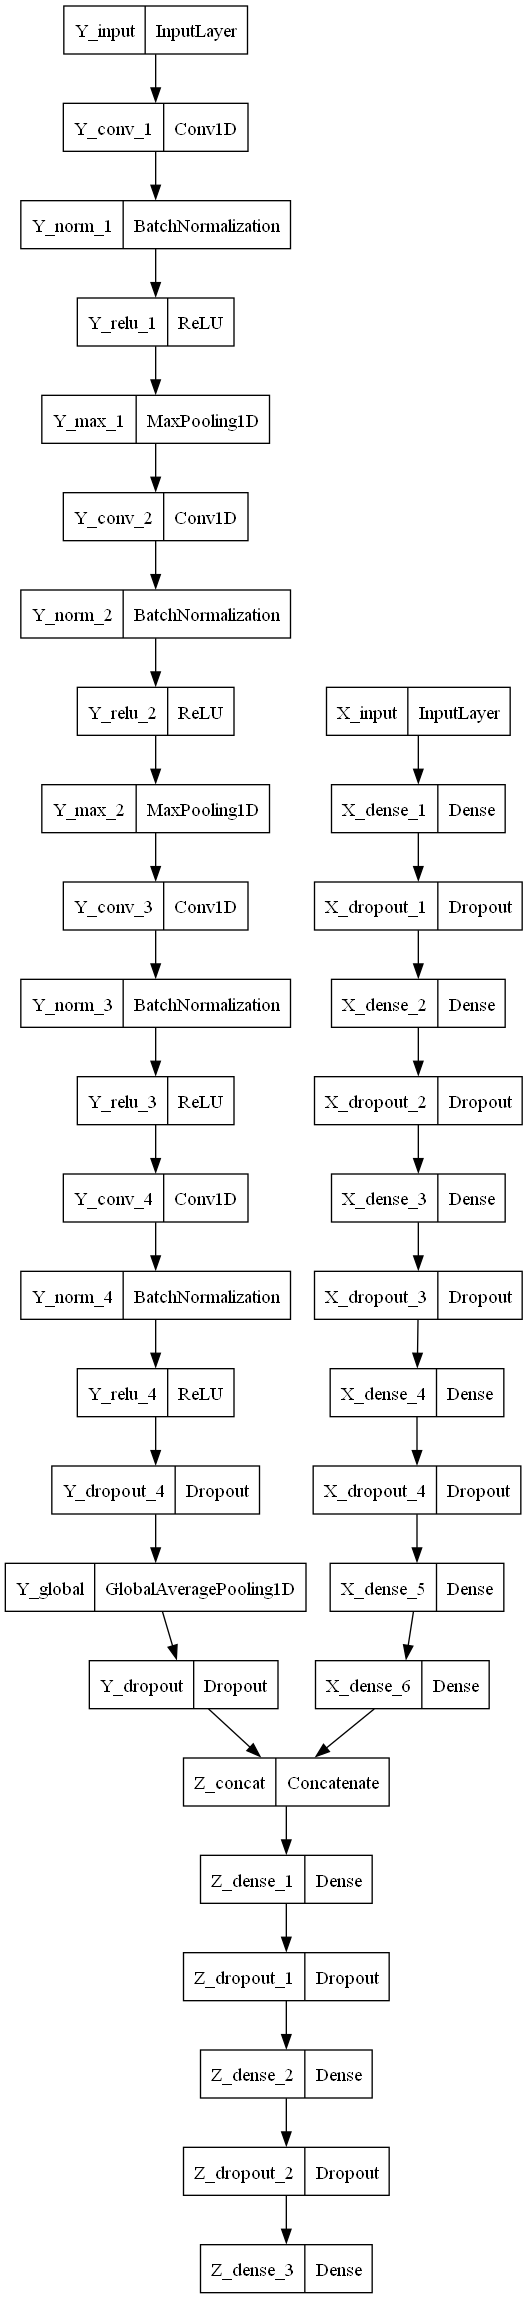

In [37]:
Z = Concatenate(name="Z_concat")([outputX, outputY])
Z = Dense(64, activation='relu', name="Z_dense_1")(Z)
Z = Dropout(0.4, name="Z_dropout_1")(Z)
Z = Dense(64, activation='relu', name="Z_dense_2")(Z)
Z = Dropout(0.4, name="Z_dropout_2")(Z)
output = Dense(Z_train.shape[-1], activation="sigmoid", name="Z_dense_3")(Z)
from plot_model import plot_model
from tensorflow.keras.utils import plot_model
# from keras.utils.vis_utils import plot_model
# from tensorflow import keras

modelZ = tf.keras.Model(inputs=[X_input, Y_input], outputs=output)
# # tf.keras.utils.plot_model(modelZ, show_shapes=True)
# plot_model(modelZ, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)
plot_model(modelZ)#, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [38]:
adam = optimizers.legacy.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0005)
modelZ.compile( loss= 'binary_crossentropy', optimizer= adam, metrics=['binary_accuracy', 'Precision', 'Recall'])

callback = [
    callbacks.ModelCheckpoint( monitor= 'val_binary_accuracy', save_best_only= True, filepath= root_path+'model'),
    callbacks.EarlyStopping( monitor= 'val_binary_accuracy', restore_best_weights= True, patience=10, min_delta= 0.001),
    callbacks.TensorBoard(log_dir= root_path+'/logs')
]

fitting = modelZ.fit( [X_train_scaled, Y_train_scaled], Z_train, epochs=20, batch_size=128, callbacks= callback, validation_data=([X_val_scaled, Y_val_scaled] , Z_val))

Epoch 1/20
39/40 [============================>.] - ETA: 0s - loss: 0.5264 - binary_accuracy: 0.7596 - precision: 0.5440 - recall: 0.2841INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


40/40 [==============================] - 13s 276ms/step - loss: 0.5263 - binary_accuracy: 0.7596 - precision: 0.5439 - recall: 0.2843 - val_loss: 0.7342 - val_binary_accuracy: 0.7496 - val_precision: 0.5286 - val_recall: 0.3133
Epoch 2/20
39/40 [============================>.] - ETA: 0s - loss: 0.4870 - binary_accuracy: 0.7843 - precision: 0.6182 - recall: 0.3766INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


40/40 [==============================] - 10s 242ms/step - loss: 0.4869 - binary_accuracy: 0.7843 - precision: 0.6181 - recall: 0.3767 - val_loss: 0.5353 - val_binary_accuracy: 0.7580 - val_precision: 0.5497 - val_recall: 0.3673
Epoch 3/20
39/40 [============================>.] - ETA: 0s - loss: 0.4746 - binary_accuracy: 0.7939 - precision: 0.6321 - recall: 0.4359INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


40/40 [==============================] - 10s 253ms/step - loss: 0.4746 - binary_accuracy: 0.7939 - precision: 0.6319 - recall: 0.4358 - val_loss: 0.5272 - val_binary_accuracy: 0.7668 - val_precision: 0.5761 - val_recall: 0.3796
Epoch 4/20
40/40 [==============================] - 7s 183ms/step - loss: 0.4733 - binary_accuracy: 0.7950 - precision: 0.6347 - recall: 0.4388 - val_loss: 0.5179 - val_binary_accuracy: 0.7658 - val_precision: 0.5629 - val_recall: 0.4313
Epoch 5/20
39/40 [============================>.] - ETA: 0s - loss: 0.4718 - binary_accuracy: 0.7952 - precision: 0.6334 - recall: 0.4447INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


40/40 [==============================] - 10s 243ms/step - loss: 0.4716 - binary_accuracy: 0.7953 - precision: 0.6335 - recall: 0.4448 - val_loss: 0.5088 - val_binary_accuracy: 0.7676 - val_precision: 0.5719 - val_recall: 0.4113
Epoch 6/20
39/40 [============================>.] - ETA: 0s - loss: 0.4672 - binary_accuracy: 0.7972 - precision: 0.6336 - recall: 0.4630INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


40/40 [==============================] - 10s 250ms/step - loss: 0.4673 - binary_accuracy: 0.7972 - precision: 0.6337 - recall: 0.4628 - val_loss: 0.5155 - val_binary_accuracy: 0.7678 - val_precision: 0.5782 - val_recall: 0.3850
Epoch 7/20
40/40 [==============================] - 7s 181ms/step - loss: 0.4666 - binary_accuracy: 0.7994 - precision: 0.6418 - recall: 0.4617 - val_loss: 0.5084 - val_binary_accuracy: 0.7634 - val_precision: 0.5575 - val_recall: 0.4228
Epoch 8/20
40/40 [==============================] - 7s 179ms/step - loss: 0.4668 - binary_accuracy: 0.7974 - precision: 0.6354 - recall: 0.4601 - val_loss: 0.5126 - val_binary_accuracy: 0.7634 - val_precision: 0.5568 - val_recall: 0.4275
Epoch 9/20
39/40 [============================>.] - ETA: 0s - loss: 0.4646 - binary_accuracy: 0.7975 - precision: 0.6326 - recall: 0.4671INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


INFO:tensorflow:Assets written to: ./ptb-xl-dataset-1.0.3\model\assets


40/40 [==============================] - 10s 243ms/step - loss: 0.4645 - binary_accuracy: 0.7975 - precision: 0.6330 - recall: 0.4672 - val_loss: 0.5082 - val_binary_accuracy: 0.7680 - val_precision: 0.5802 - val_recall: 0.3796
Epoch 10/20
40/40 [==============================] - 7s 183ms/step - loss: 0.4676 - binary_accuracy: 0.7968 - precision: 0.6348 - recall: 0.4553 - val_loss: 0.5155 - val_binary_accuracy: 0.7630 - val_precision: 0.5622 - val_recall: 0.3873
Epoch 11/20
40/40 [==============================] - 7s 181ms/step - loss: 0.4710 - binary_accuracy: 0.7936 - precision: 0.6211 - recall: 0.4632 - val_loss: 0.5109 - val_binary_accuracy: 0.7650 - val_precision: 0.5651 - val_recall: 0.4051
Epoch 12/20
40/40 [==============================] - 7s 180ms/step - loss: 0.4694 - binary_accuracy: 0.7957 - precision: 0.6327 - recall: 0.4507 - val_loss: 0.5119 - val_binary_accuracy: 0.7630 - val_precision: 0.5559 - val_recall: 0.4259
Epoch 13/20
40/40 [==============================] - 7s

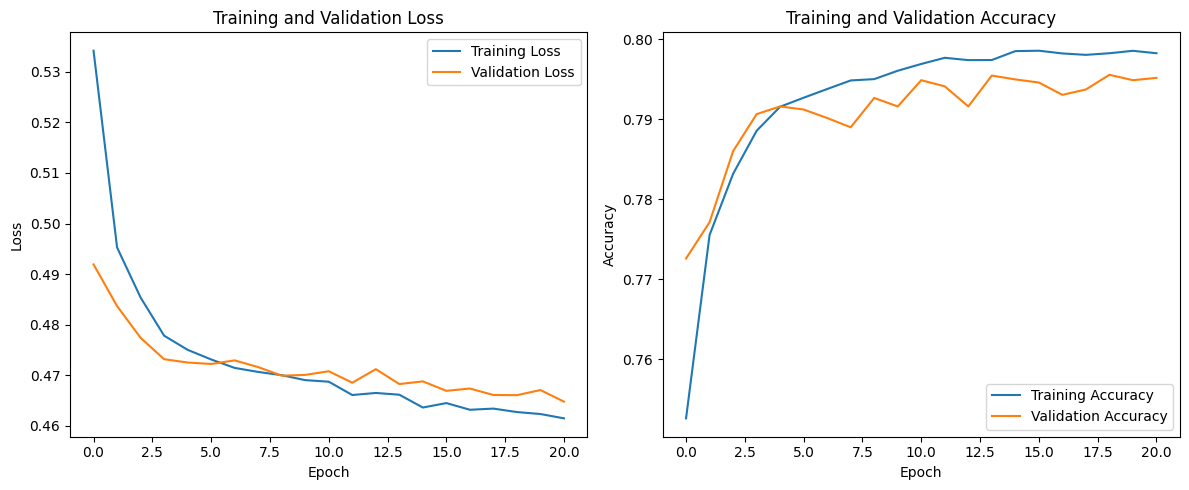

In [42]:
import matplotlib.pyplot as plt

# Assuming 'fitting' is the history object returned by model.fit

# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fitting.history['loss'], label='Training Loss')
plt.plot(fitting.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(fitting.history['binary_accuracy'], label='Training Accuracy')
plt.plot(fitting.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [92]:
Z_val.shape
Z_val
# y_true_classes = np.argmax(Z_val, axis=1)


NORM  MI  STTC  CD  HYP
7         0   1     0   0    0
9         1   0     0   0    0
16        0   0     0   0    0
17        0   0     0   0    0
19        0   0     0   0    0
...     ...  ..   ...  ..  ...
19851     1   0     0   0    0
19889     1   0     0   0    0
19914     0   0     0   1    0
19935     0   0     0   1    0
19939     0   0     0   1    0

[2074 rows x 5 columns]

65/65 [==============================] - 1s 8ms/step
(2074, 5) (2074, 5)


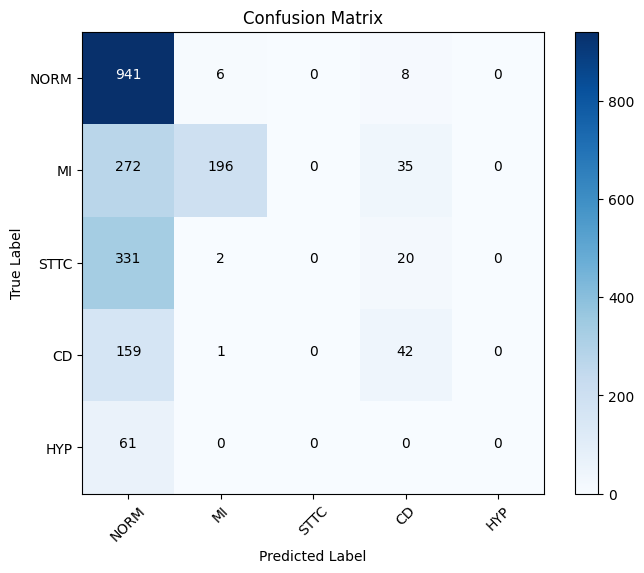

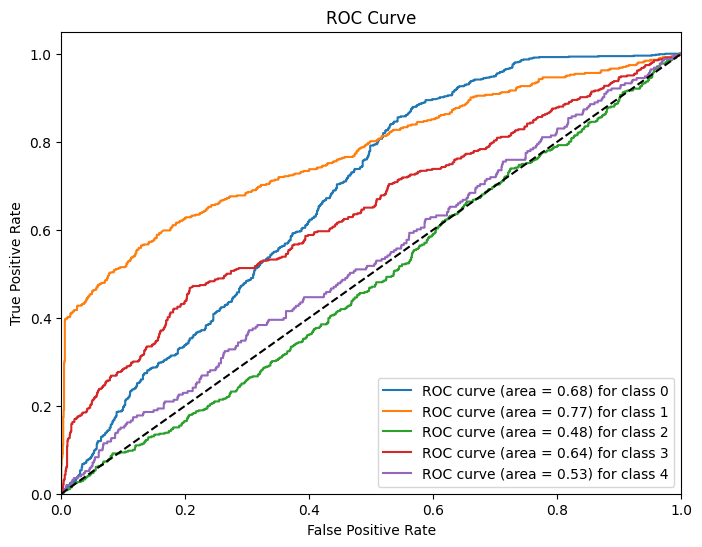

In [96]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already trained your model and obtained predictions on the validation set
# modelZ.predict([X_val_scaled, Y_val_scaled])

# Compute confusion matrix
y_pred = modelZ.predict([X_val_scaled, Y_val_scaled])
print(y_pred.shape,Z_val.shape)
Z_val = np.array(Z_val)
Z_val_reshaped = Z_val.reshape(-1, num_classes)
y_pred_reshaped = y_pred.reshape(-1, num_classes)


y_pred_classes =np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(np.array(Z_val), axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['NORM','MI','STTC','CD','HYP']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Z_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [43]:
from keras import layers, models
from tensorflow.keras.utils import plot_model
plt.figure(figsize=(10, 10))

plot_model(modelZ)
plt.show()



<Figure size 1000x1000 with 0 Axes>